# Imports

In [166]:
import re
import random
import numpy as np
from numpy import percentile,median
import pandas as pd
from itertools import accumulate, chain, repeat, tee
import itertools
import category_encoders as ce
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import sklearn
import sklearn.datasets
import sklearn.ensemble
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,ShuffleSplit
from sklearn.metrics import mean_squared_error,r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.linear_model import LinearRegression
from sklearn import neighbors

# Functions

In [167]:
# Output the mapping from categorical to numerical values for each feature in a dataset.
# Given both categorical and encoded dataframes, works only if mapping is 1 - 1 
def dictionary(original,encoded):
    dict={}
    categorical = original.select_dtypes(include=['object']).columns.values
    for i in categorical:
        dict[i]={}
        a = list(zip(original[i].values,encoded[i].values))
        unique_pairs=[]
        keys=[]
        for x in a:
            if x not in unique_pairs:
                unique_pairs.append(x)
        for j in unique_pairs:
            keys.append(j[0])
        if len(keys) > len(set(keys)):
            print(" mapping is not 1 - 1 ")
            return None
        else:
            l = {}
            for j in unique_pairs:
                l[j[0]] = j[1]
        dict[i] = l
    return dict

# Split or just suffle, encode data and return dictionary of encoding
def prepare_data(dataset,target,features,split=True):
    dataset = dataset[dataset[target].notnull()]
    if split==True:
        X = dataset[features]
        y = dataset[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        encoder = ce.leave_one_out.LeaveOneOutEncoder()
        encoder.fit(X_train,y_train)
        X_train_encoded = encoder.transform(X_train)
        X_test_encoded = encoder.transform(X_test)
        dict_ = dictionary(pd.concat([X_train,X_test],  ignore_index=True),\
                           pd.concat([X_train_encoded,X_test_encoded], ignore_index=True))
        return X_train_encoded, X_test_encoded, y_train, y_test, dict_
    else:
        shuffled = dataset.sample(frac=1)
        X = shuffled[features]
        y = shuffled[target]
        encoder = ce.leave_one_out.LeaveOneOutEncoder()
        encoder.fit(X,y)
        X_encoded = encoder.transform(X)
        dict_ = dictionary(X,X_encoded)
        return X_encoded,y, dict_

# Calculate 95% Confidence Intervals
def ci(scores):
    alpha =0.5
    lower_p = alpha/2.0
    lower = max(0.0, percentile(scores, lower_p))
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = min(1.0, percentile(scores, upper_p))
    return list(map(lambda x: round(x,4),[lower,median(scores),upper]))

# Relative Root Mean Square
def rrmse(actual,predicted):
    avrg = sum(actual)/len(actual)
    numerator = sum([(x - y)**2 for x,y in zip(actual,predicted)])   
    denominator = sum([(x - avrg)**2 for x in actual])
    return numerator/denominator

my_rrmse = make_scorer(rrmse, greater_is_better=True)

# Cross validation to find best parameters
def best_params(X,y,model,grid):
    random = GridSearchCV(model,grid,cv=5,n_jobs=8,verbose=0)
    random.fit(X,y)
    return random.best_params_

# Break a list xs into n equal sublists
def chunk(xs, n):
    assert n > 0
    L = len(xs)
    s, r = divmod(L, n)
    widths = chain(repeat(s+1, r), repeat(s, n-r))
    offsets = accumulate(chain((0,), widths))
    b, e = tee(offsets)
    next(e)
    return [xs[s] for s in map(slice, b, e)]

# Get n unique perturbations of a set s
def findsubsets(s, n): 
    return [list(i) for i in itertools.combinations(s, n)] 

# Strech a shorter list based on where a longer has repeating streaks
def stretch(longer,shorter):
    if len(longer) <= len(shorter):
        return shorter
    list_set = list(set(longer))
    res = shorter.copy()
    for i in sorted(list_set):
        counter = longer.count(i)
        if counter > 1:
            index = longer.index(i)
            for j in range(counter -1):
                res.insert(index,res[index])
    return res

# Grid search Cross Validation parameter tuning
def best_params(model,X,y,target_name,grid):
    search = GridSearchCV(model,grid,cv=5,n_jobs=8,verbose=10)
    # Fit the random search model
    search.fit(X,y)
    print(search.best_params_)
    results = {}
    results['model'] = type(model).__name__
    results['target'] = target
    results['params'] = search.best_params_
  # write results to file
    return results

# Plot partial dependence for all features
def plot_pd(feature,cat_features,model, X,dict_):
    labels,locs,rotation = (None,None,0)
    y,x = partial_dependence(model, X, [feature])
    x_,y_ = x[0].tolist(),y[0].tolist()
    title = 'Partial Dependence for '+feature
    plt.figure(figsize=(20,10))
    plt.title(title, fontsize =20)
    if feature in cat_features:
        rotation = (0,90)[feature =='Cells']
        locs = list(dict_[feature].values())
        labels = list(dict_[feature].keys())
        zipped = list(zip(locs,labels))
        sorted_zipped = sorted(zipped, key=lambda tup: tup[0])
        locs = [pair[0] for pair in sorted_zipped]
        labels = [pair[1] for pair in sorted_zipped]
        x_ = list(range(len(locs)))
        y_ = stretch(locs, y_)
        locs = x_
        width = (0.8,0.2)[len(locs) == 2]
        if feature == 'Ion':
            zipped = list(zip(x_,y_,labels))
            sorted_zipped = sorted(zipped, key=lambda tup: int(re.search(r'\d+', tup[2]).group()))
            x_ = list(range(len(locs)))
            y_ = [pair[1] for pair in sorted_zipped]
            labels = [pair[2] for pair in sorted_zipped]
        plt.xticks(locs,labels,rotation=rotation)
        plt.xlabel(feature,fontsize=16)
        plt.ylabel('Predicted Outcome',fontsize=16)
        plt.bar(x_,y_,width)
        plt.show()
        plt.close()
    else:
        plt.xlabel(feature,fontsize=16)
        plt.ylabel('Predicted Outcome',fontsize=16)
        plt.plot(x_,y_,'tab:red')
        ymax = max(y_)
        xpos = y_.index(ymax)
        xmax = x_[xpos]
        label = feature + '= ' + str(round(xmax,2))
        plt.annotate(label, xy=(xmax, ymax))
        plt.show()
        plt.close()
    return None

def performance(y_test, preds,model,target):
    """
    Get predictions and true values and scatter plot them.
    Additionally plot a linear regression line on the points
    of the Scatter plot and get its equation y = a *x + b.
    The closer the line to the y = x line the better the prediction.
    Additionally break the preds and truth paired set into 4 equal
    chunks and plot the mean and variance in order to visualize
    any trend to the error of the prediction.
    """

    model_name = type(model).__name__
    rmse = mean_squared_error(preds,y_test)
    r2 = r2_score(y_test,preds)
    
    #    separate truth and preds in chunks
    y_test_sorted, preds_sorted = zip(*sorted(zip(y_test, preds)))
    zipped = list(zip(preds_sorted,y_test_sorted))
    lists = chunk(zipped,4)
    
    #    make linear regression line on points (pred,truth)
    preds_extended = sm.add_constant(preds)
    linear_regressor = sm.OLS(y_test,preds_extended).fit()
    #   alpha coefficient of linear regression
    a = round(linear_regressor.params[1],5)
    #   intercept of linear regression
    b = round(linear_regressor.params[0],5)
    #   get the sign of the intercept
    score = lambda i: ("+" if i > 0 else "") + str(i)
    Y = a*y_test +b
    #   calculate the limits of the graph, as the min and max of both preds and truths
    min_ = np.min(np.array(np.min(y_test),np.min(preds)))
    max_ = np.max(np.array(np.max(y_test),np.max(preds)))
    #   array of x's for identity line
    x = np.linspace(min_,max_, 1000)
    
    ############## PLOT ##############
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(nrows=3, ncols=4,height_ratios=[2, 2,1])
    # H0: The beta coefficient(slope) of the X variable is zero
    label = 'regresssion:'+'y='+str(a)+'x'+score(b) +\
    '\nPvalue: ' + str(np.format_float_scientific(linear_regressor.pvalues[1],precision=4))\
    +'\nRMSE '+str(round(rmse,6))+\
    '\n'+'R^2: '+str(round(r2,6))
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(y_test,Y,'green',label=label)
    # scatter plot of pred and truths
    ax1.scatter(y_test, preds, alpha=0.5,label='preds')
    ax1.set_xlim(min_,max_)
    ax1.set_ylim(min_,max_)
    ax1.set_xlabel('true values',fontsize = 16)
    ax1.set_ylabel('predited',fontsize=16)
    ax1.set_title(model_name+' '+target,fontsize = 16)
    ax1.legend(fontsize=16)
   
    ax=[None]*4
    means=[]
    vars_=[]
    for list_,index in zip(lists,range(4)):
        res = [pred - truth for pred, truth in list_ ]
        mean = np.mean(res)
        var = np.var(res)
        means.append(mean)
        vars_.append(var)
        ax[index] = fig.add_subplot(gs[2, index])
        ax[index].hist(res,bins=50,label='mean: '+str(round(mean,6)) + '\n' + 'variation: '+str(round(var,6)))
        ax[index].set_title('slice: '+str(index +1))
        ax[index].legend()
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(means, color='r',  marker='.',label='mean')
    ax2.plot(vars_ , color='g',  marker='.',label='variance')
    ax2.set_title('predicted - true means & variance',fontsize=16)
    ax2.set_xticks([])
    ax2.legend()
    plt.show()
    plt.close()
    return None

# Data

In [176]:
excel = pd.read_excel('./data/PIDE3.2+mcds.xlsx',convert_float=False)
excel.rename(columns = {'All Clusters/(Gbp*Gy)_hy':'DSBs_hy', 'AllClusters/(Gbp*Gy)_ox':'DSBs_ox'}, inplace = True) 
targets = ['ai_paper','bi_paper','DSBs_hy','DSBs_ox']
features = ['Cells','CellClass','CellOrigin','CellCycle','DNAcontent','Ion','Charge','IrradiationConditions','LET','Energy']
cat_features = ['Cells','CellCycle','Ion','CellClass','CellOrigin','IrradiationConditions']
excel.sample(frac=1).head(10)

,#ExpID,#Publication,PublicationName,#IonExp,Cells,CellClass,CellOrigin,CellCycle,DNAcontent,PhotonRadiation,...,ax_fit,bx_fit,ai_fit,bi_fit,DSB/(Gbp*Gy)_hy,Other/(Gbp*Gy)_hy,DSBs_hy,DSB/(Gbp*Gy)_ox,Other/(Gbp*Gy)_ox,DSBs_ox
800,801.0,64.0,takahashi00,8.0,T98G,t,h,a,6.0,150kVp,...,0.000000,0.061481,0.304351,0.044601,NaN,NaN,NaN,27.5,56.7,159.5
398,399.0,17.0,belli08,21.0,SQ20B,t,h,a,6.0,60Co/137Cs,...,0.158166,0.012530,0.730676,0.000000,NaN,NaN,NaN,28.1,43.6,136.2
8,9.0,1.0,chapman77,9.0,V79,n,r,G0,5.6,220kVp,...,NaN,NaN,NaN,NaN,25.8,84.3,203.6,NaN,NaN,NaN
238,239.0,13.0,furusawa00,84.0,HSG,t,h,a,6.0,200kVp,...,0.347576,0.057186,1.509374,0.000000,27.4,59.4,164.0,27.4,59.3,163.9
247,248.0,13.0,furusawa00,93.0,HSG,t,h,a,6.0,200kVp,...,0.347576,0.057186,1.520476,-0.082460,28.1,42.6,134.4,28.1,42.6,134.4
1083,1084.0,113.0,schuff02,3.0,PDV,t,r,a,5.6,137Cs,...,0.000000,0.053315,0.393310,0.395693,NaN,NaN,NaN,14.0,292.2,470.0
31,32.0,3.0,blakely79,10.0,T1,n,h,a,6.0,220kVp,...,0.233407,0.031997,0.365366,0.063240,25.9,82.6,201.0,NaN,NaN,NaN
710,711.0,53.0,scholz97,1.0,CHO,n,r,a,5.6,250kVp,...,NaN,NaN,0.945843,0.000000,NaN,NaN,NaN,27.9,48.8,145.7
920,921.0,86.0,frankenberg09,1.0,AA8,n,r,G1,5.6,200kVp,...,0.143692,0.041630,1.122644,0.000000,NaN,NaN,NaN,27.2,64.1,172.0
489,490.0,31.0,czub08,1.0,CHO,n,r,a,5.6,60Co,...,0.182657,0.017056,0.661339,0.052081,NaN,NaN,NaN,28.1,42.0,133.3


# Parameter tuning

In [ ]:
import json
import os

rf_grid = {
        'n_estimators': [10,50,100,500,1000],
        'max_features': ['log2', 'sqrt',None],
        'max_depth': [None],
        'min_samples_split': [1,2,3],
        'min_samples_leaf': [1, 2, 4,8],
        'bootstrap': [True,False],
        'criterion':['mae','mse'],
        'oob_score':[True,False],
        'max_samples':[0.9,1.0]
}

best_parameters=[]
for target in targets:
    print(target)
    X_train, X_test, y_train, y_test, encoding_dict_ = prepare_data(excel,target,features)
    model = RandomForestRegressor()
    best_parameters.append(best_params(model,X_train,y_train,target,rf_grid))

with open('best_params.txt', 'w') as param_file:
    for element in best_parameters:
        param_file.write(json.dumps(element))
        param_file.write(os.linesep)

# Performance


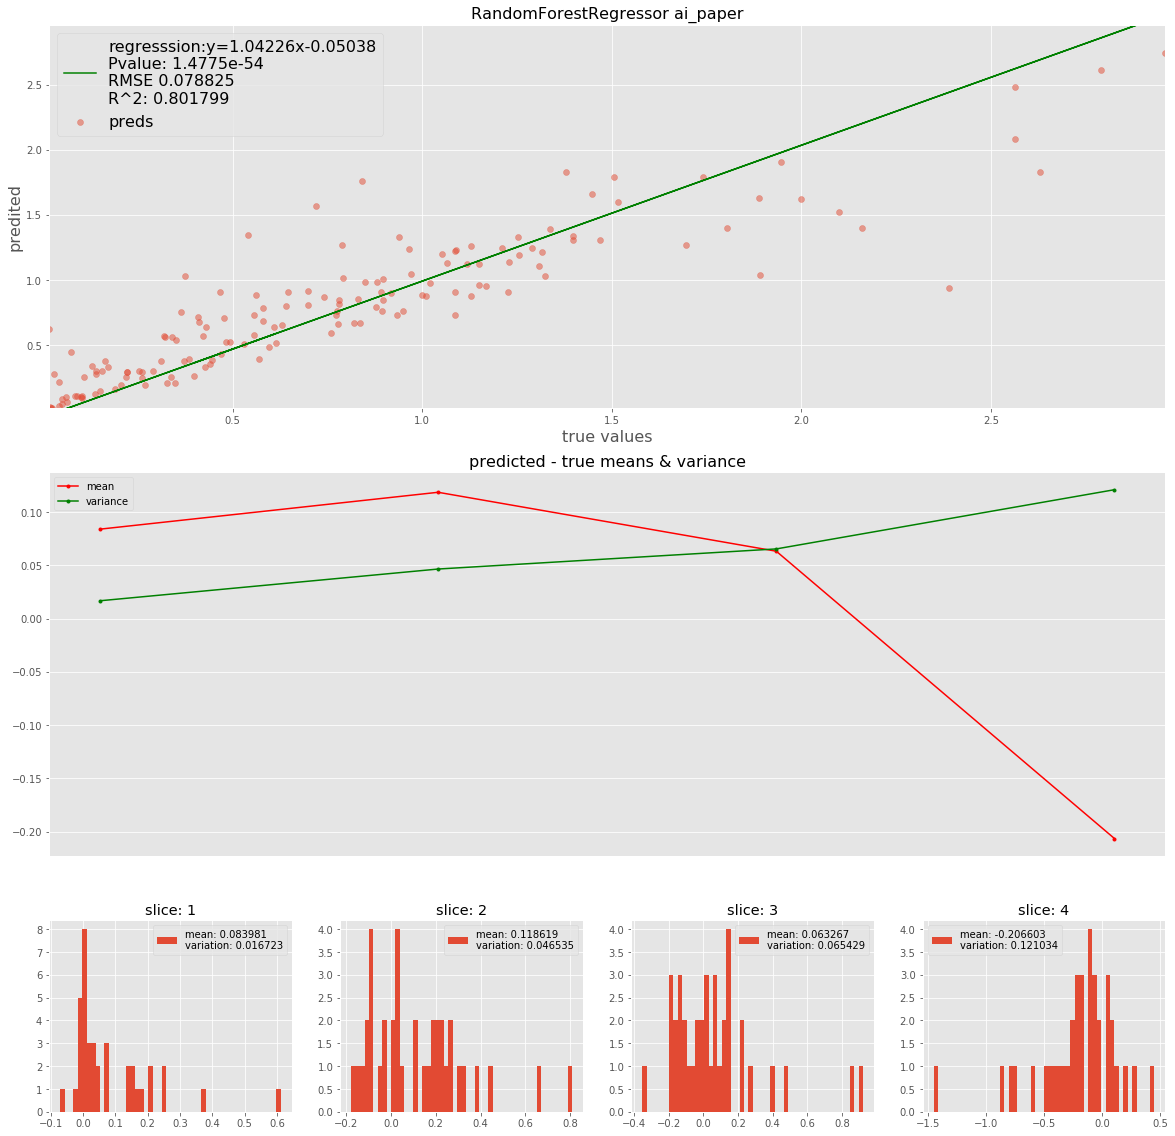

{'bootstrap': True, 'criterion': 'mae', 'max_depth': None, 'max_features': None, 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': True}


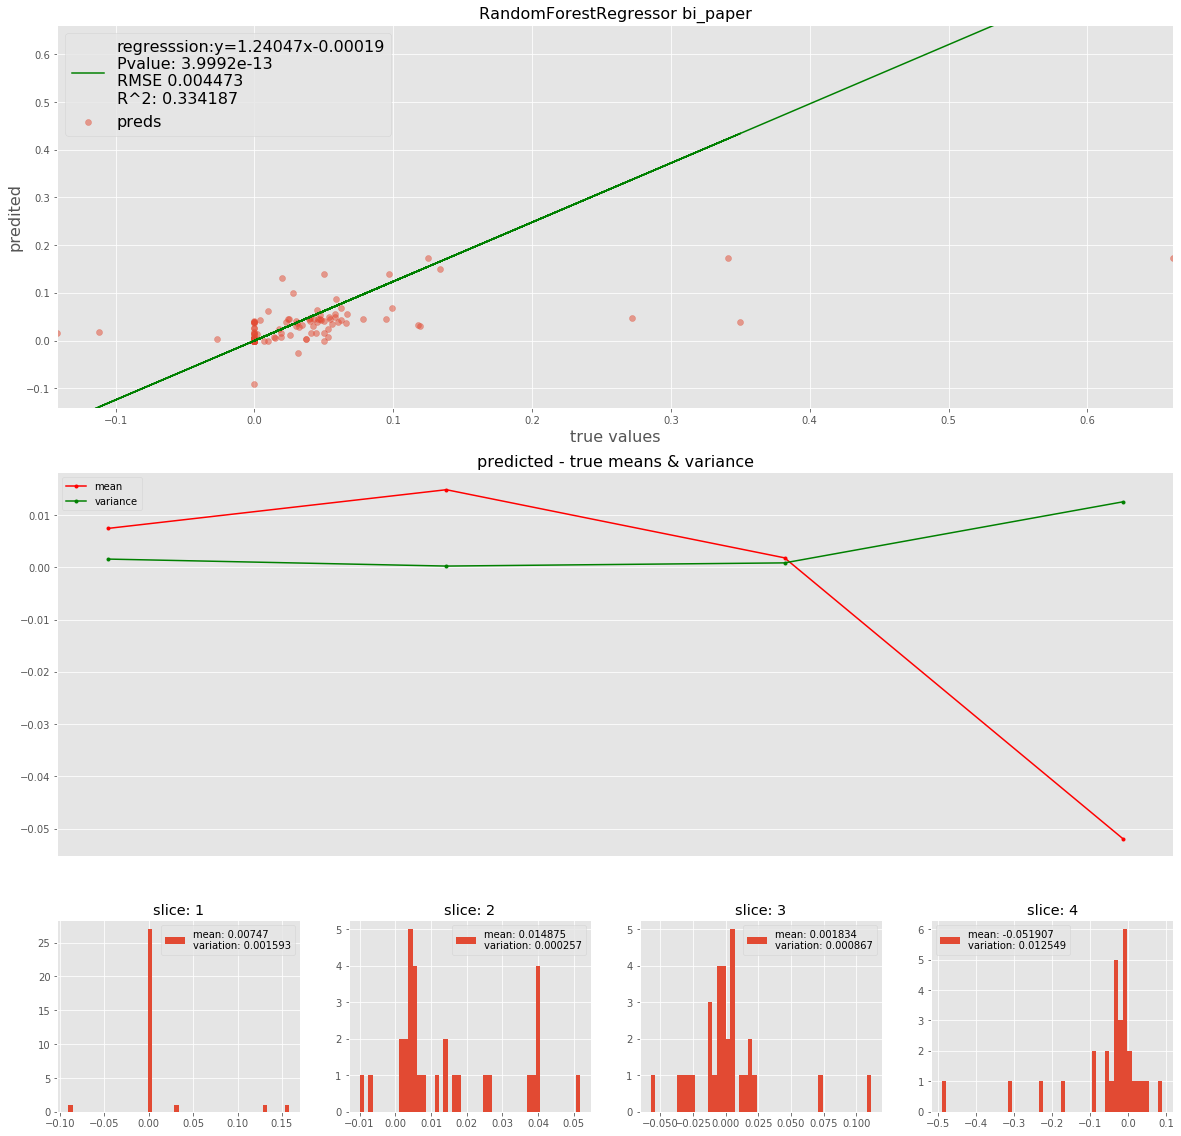

{'bootstrap': True, 'criterion': 'mae', 'max_depth': None, 'max_features': None, 'max_samples': 0.9, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': False}


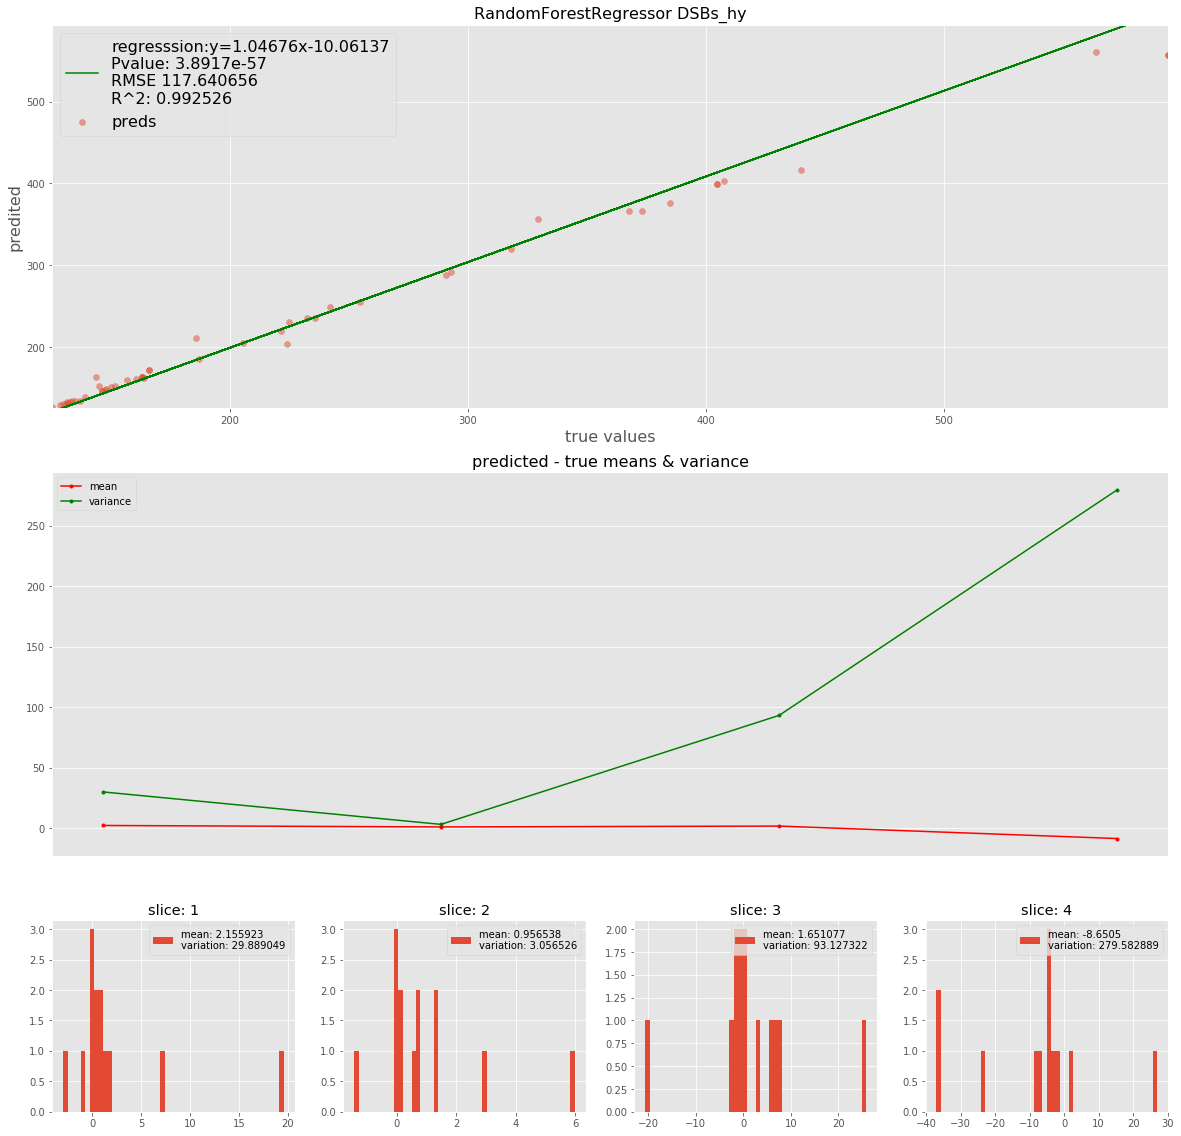

{'bootstrap': False, 'criterion': 'mse', 'max_depth': None, 'max_features': 'log2', 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': False}


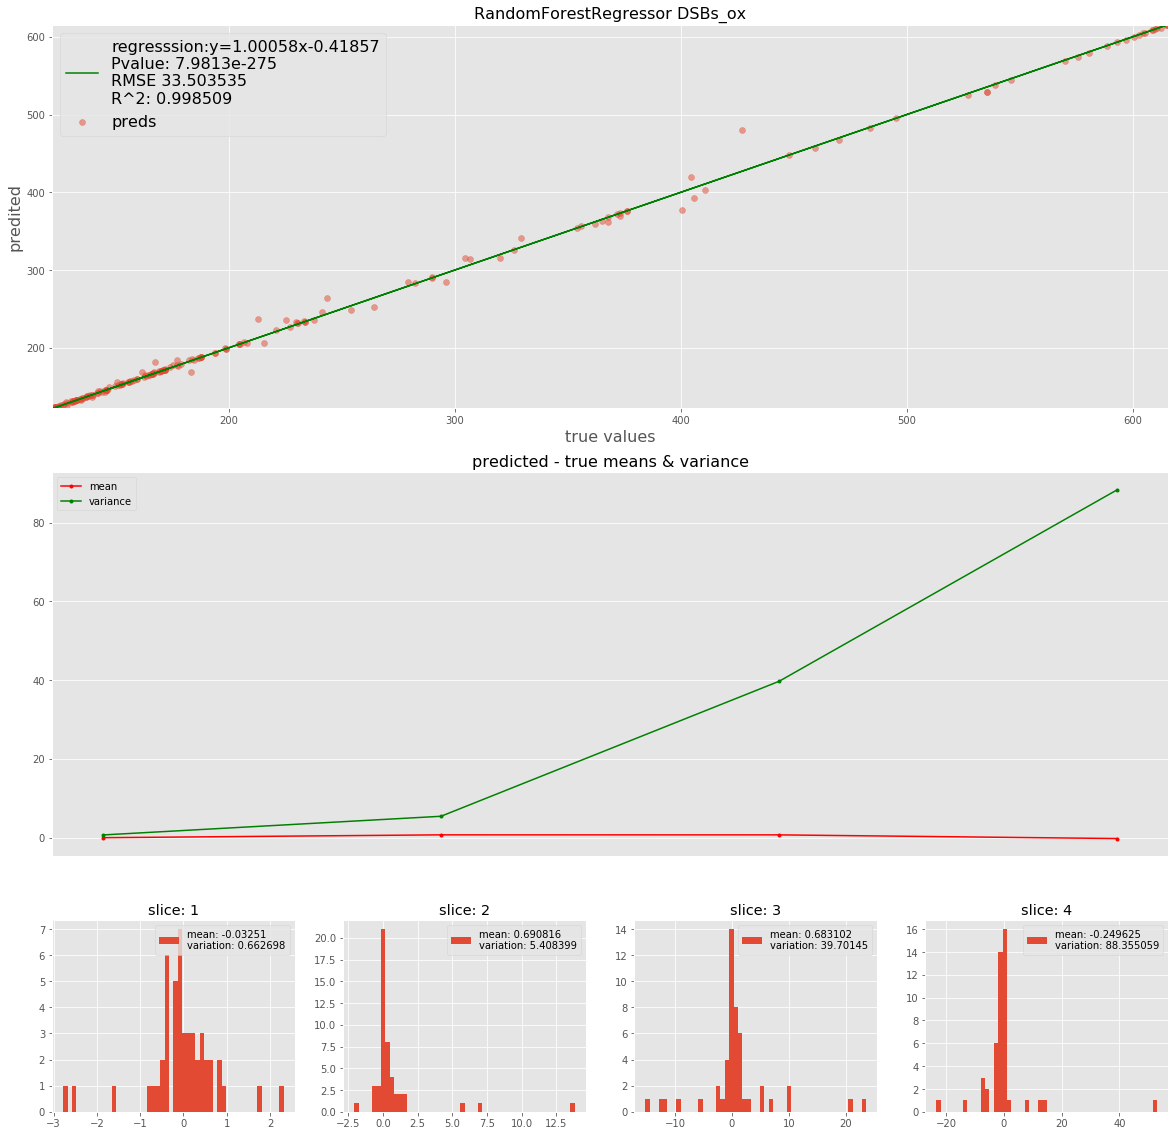

{'bootstrap': True, 'criterion': 'mae', 'max_depth': None, 'max_features': None, 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': True}


In [170]:
parameters = []
with open('best_params.txt') as f:
    for jsonObj in f:
        paramDict = json.loads(jsonObj)
        parameters.append(paramDict)
# print(parameters)

for obj in parameters:
    target = obj['target']
    X_train, X_test, y_train, y_test, encoding_dict_ = prepare_data(excel,target,features)
    model = RandomForestRegressor()
    params = obj['params']
    model.set_params(**params)
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    test = np.asarray(y_test)
    performance(test,preds, model, target)
    print(params)

# Bootstrap Confidence Intervals

In [171]:
from sklearn.utils import resample
for obj in parameters:
    target = obj['target']
    columns = [i for i in features]
    columns.append(target)
    data = excel[columns][excel[target].notnull()]
    values = data.values
    # configure bootstrap
    n_iterations = 100
    n_size = int(len(data) * 0.9)
    # run bootstrap
    stats = []
    for i in range(n_iterations):

        # prepare train and test sets
        train = resample(values, n_samples=n_size)
        test = np.array([x for x in values if x.tolist() not in train.tolist()])

        # name them more sensibly
        X_train = train[:,:-1]
        y_train = train[:,-1]
        X_test = test[:,:-1]
        y_test = test[:,-1]

        # encode them
        encoder = ce.leave_one_out.LeaveOneOutEncoder()
        encoder.fit(X_train,y_train)
        X_train_encoded = encoder.transform(X_train)
        X_test_encoded = encoder.transform(X_test)

        # fit model
        model = RandomForestRegressor()
        params = obj['params']
        model.set_params(**params)
        model.fit(X_train_encoded, y_train)

        # evaluate model
        predictions = model.predict(X_test_encoded)
        score = rrmse(y_test, predictions)
        stats.append(score)
    # confidence intervals
    print(ci(stats),'\t', target)

[0.205, 0.2738, 0.3587] 	 ai_paper
[0.6619, 0.8398, 1.0] 	 bi_paper
[0.0058, 0.0211, 0.1338] 	 DSBs_hy
[0.0008, 0.0018, 0.0153] 	 DSBs_ox


# Statistical significance

In [172]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import ttest_rel
def statistical_model(X,y,target,features):
    dataset = pd.concat([X,y],axis=1)
    formula = target + ' ~ '+' + '.join(features)
    model = smf.glm(formula = formula,data=dataset, family=sm.families.Poisson()).fit()
#     model = smf.ols(formula ,data=dataset).fit()
    return model
    
families =[
    sm.families.Gamma(),
    sm.families.Binomial(),
    sm.families.Gaussian(),
    sm.families.Poisson(),
    
]
for obj in parameters:
    target = obj['target']
    print(target)
    stat_mse=[]
    rf_mse = []
    for i in range(10):
        dataset = excel[excel[target].notnull()]
        X = dataset[features]
        y = dataset[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        encoder = ce.leave_one_out.LeaveOneOutEncoder()
        encoder.fit(X_train,y_train)
        X_train_encoded = encoder.transform(X_train)
        X_test_encoded = encoder.transform(X_test)
        
        model = RandomForestRegressor()
        params = obj['params']
        model.set_params(**params)
        model.fit(X_train_encoded,y_train)
        rf_preds = model.predict(X_test_encoded)
        rf_mse.append(mean_squared_error(y_test,rf_preds))

        stat_model = statistical_model(X_train_encoded,y_train,target,features)
        stat_preds = stat_model.predict(X_test_encoded)
        stat_mse.append(mean_squared_error(y_test,stat_preds))
        
    stat, p = ttest_rel(stat_mse, rf_mse)
    print('\tMean rf_mse=%.3f,\n\tMean stat_mse=%.3f,\n\tStatistics=%.3f,\n\tp=%s' \
          % (sum(rf_mse)/len(rf_mse),sum(stat_mse)/len(stat_mse),stat, np.format_float_scientific(p,precision=3)))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('\tSame distributions (fail to reject H0)')
    else:
        print('\tDifferent distributions (reject H0)')


ai_paper
	Mean rf_mse=0.096,
	Mean stat_mse=0.199,
	Statistics=9.931,
	p=3.792e-06
	Different distributions (reject H0)
bi_paper
	Mean rf_mse=0.007,
	Mean stat_mse=0.008,
	Statistics=2.499,
	p=3.393e-02
	Different distributions (reject H0)
DSBs_hy
	Mean rf_mse=184.129,
	Mean stat_mse=1964.321,
	Statistics=16.548,
	p=4.795e-08
	Different distributions (reject H0)
DSBs_ox
	Mean rf_mse=62.837,
	Mean stat_mse=3037.547,
	Statistics=16.103,
	p=6.083e-08
	Different distributions (reject H0)


# Interpretations

ai_paper global Interpretations
ai_paper Feature Importances
ai_paper Partial Dependene


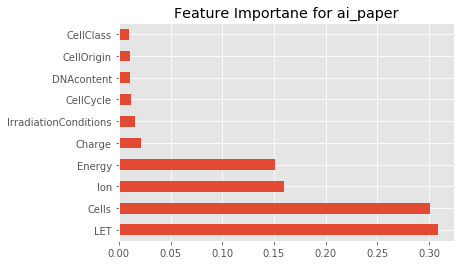

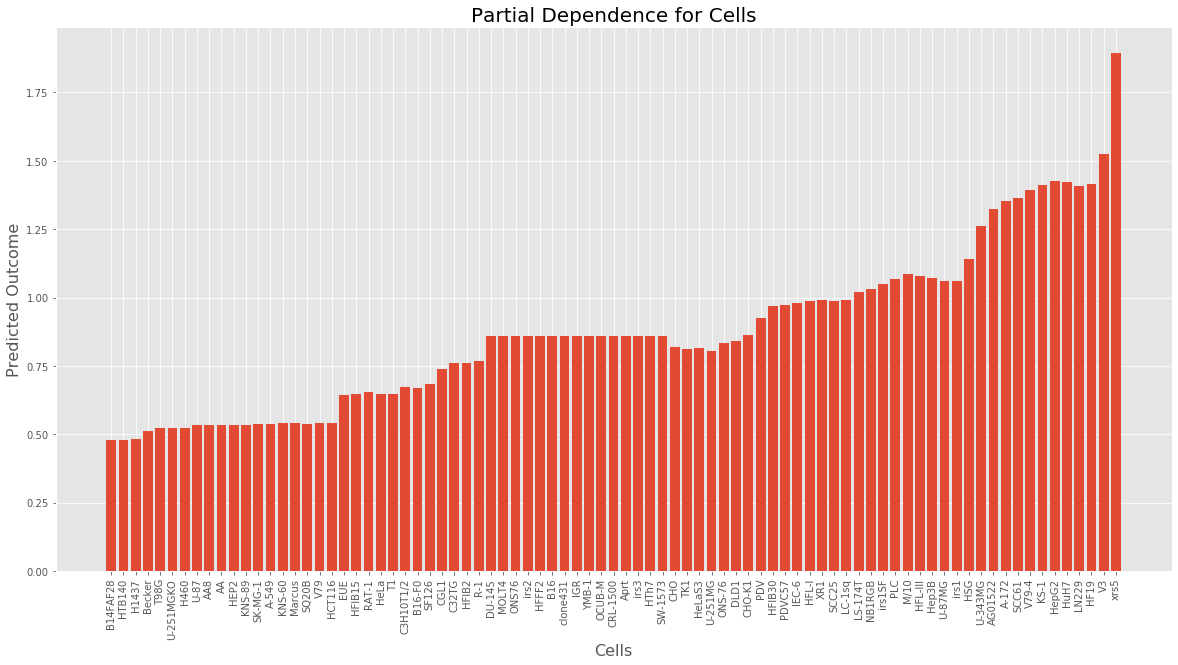

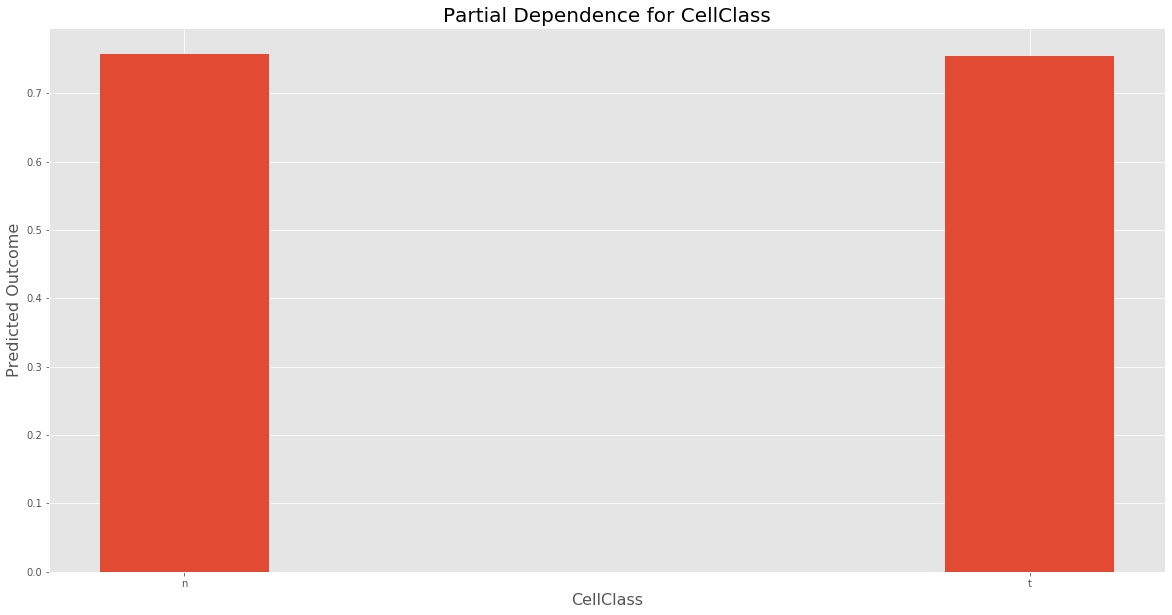

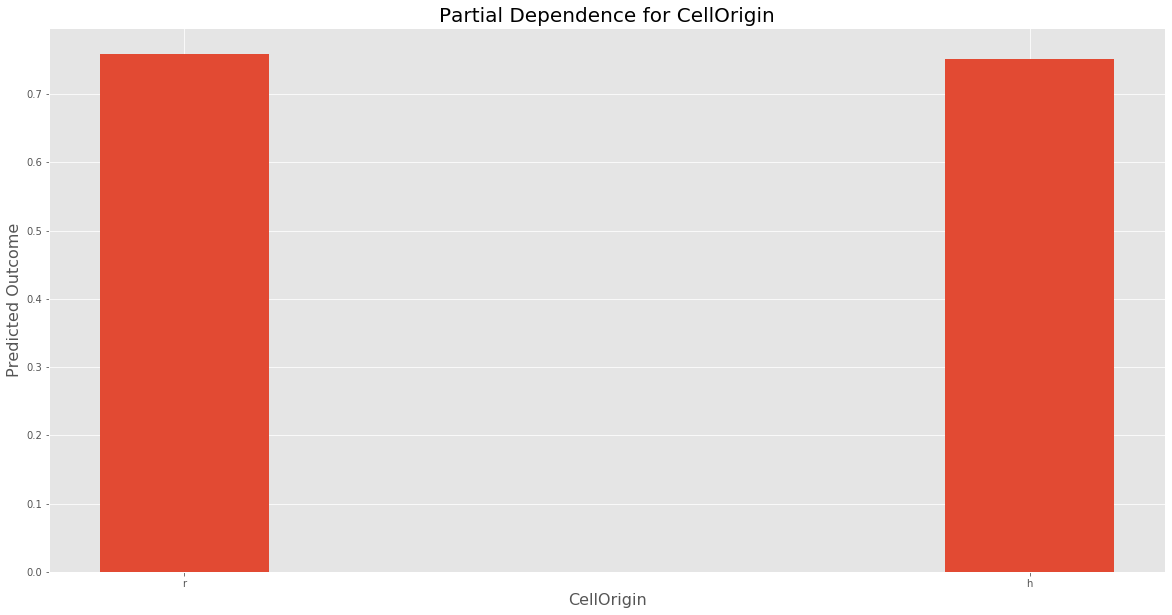

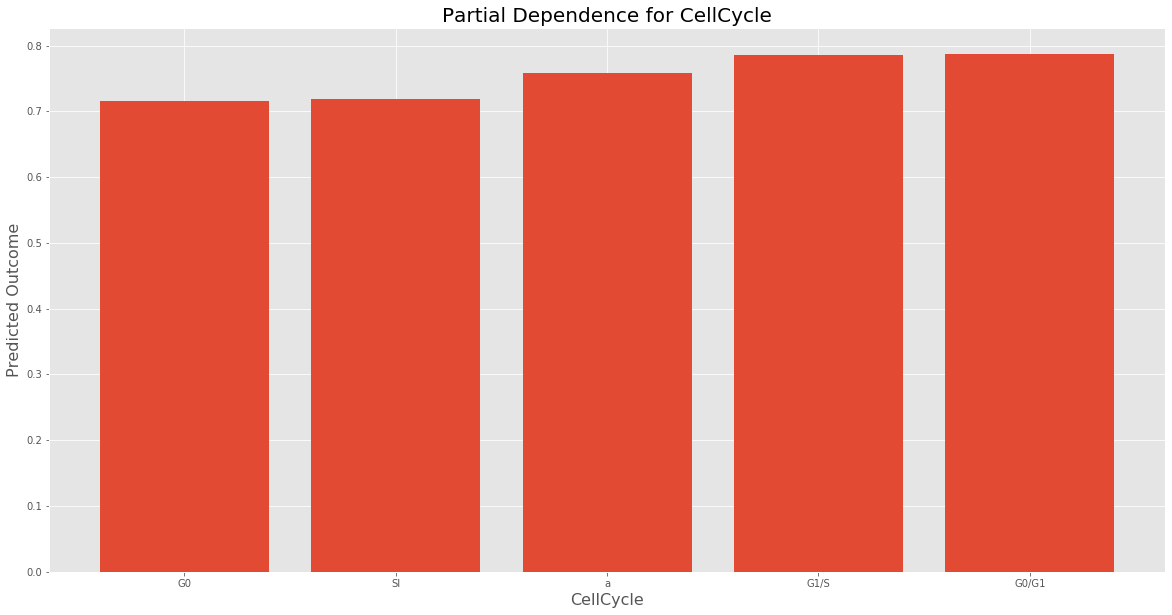

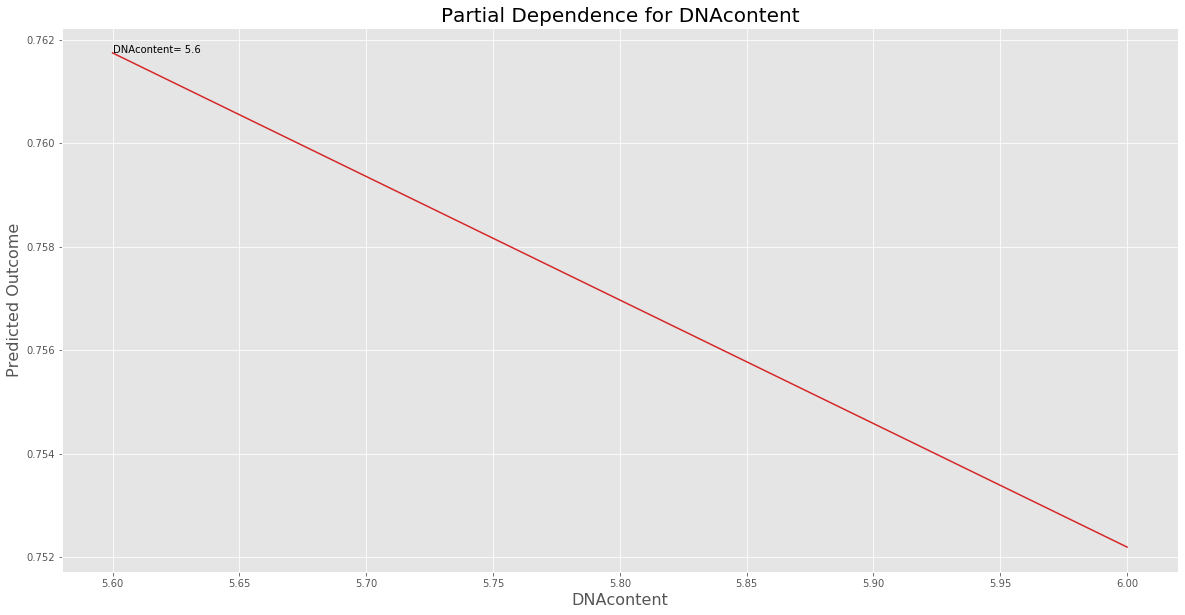

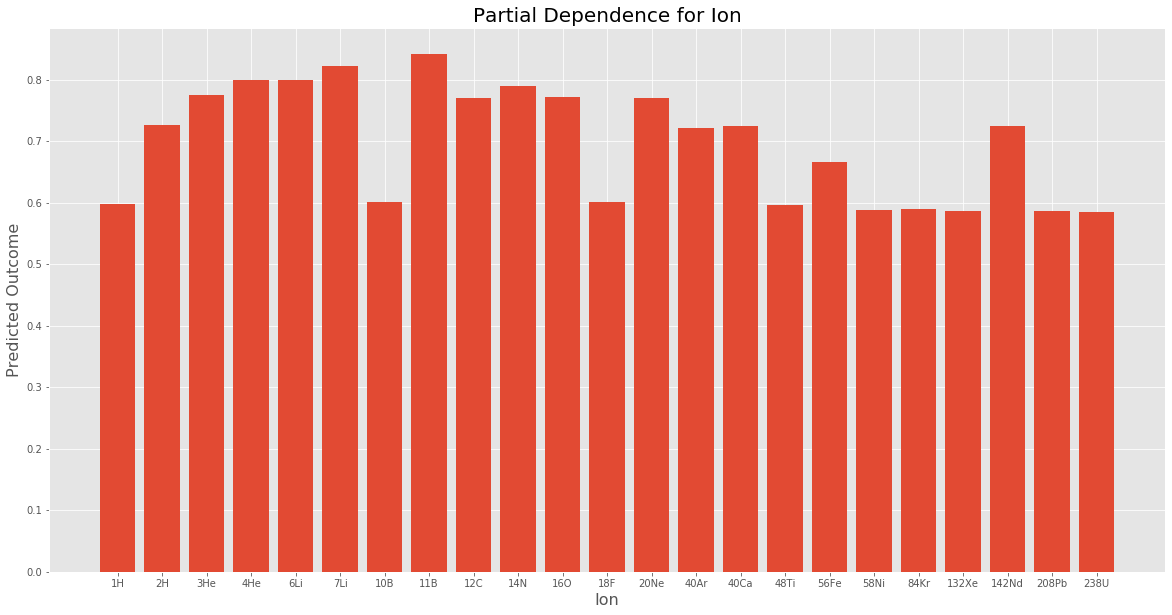

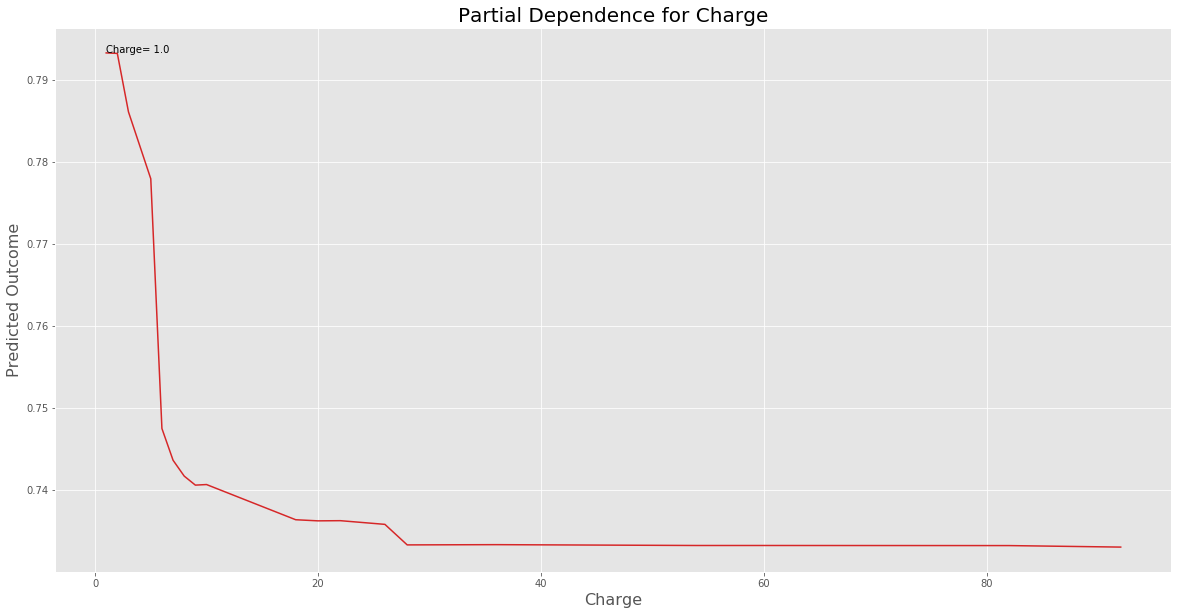

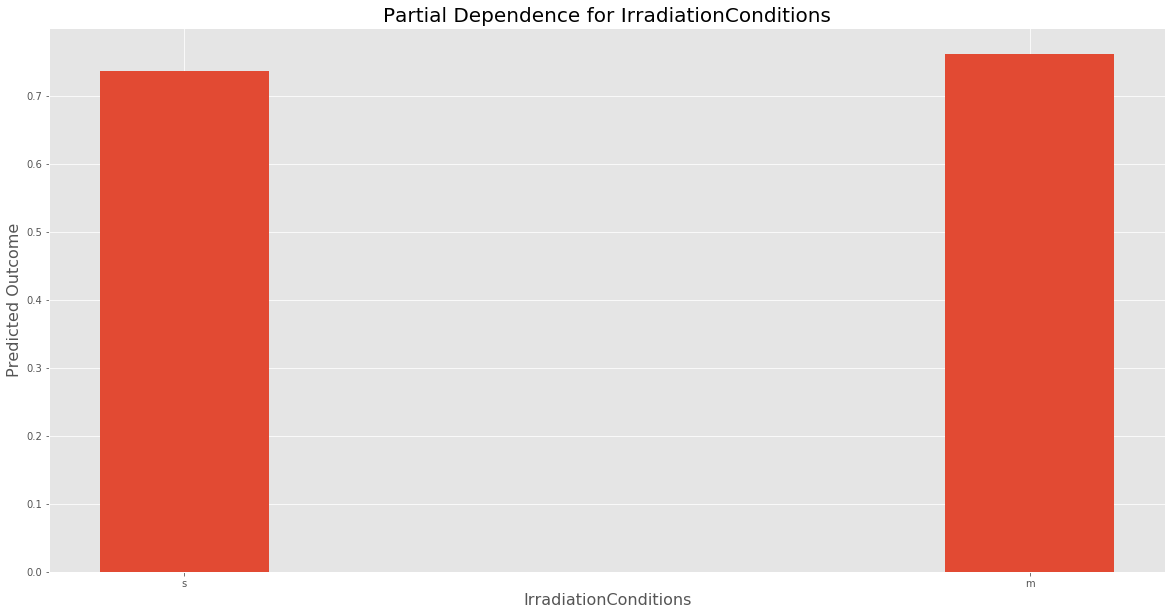

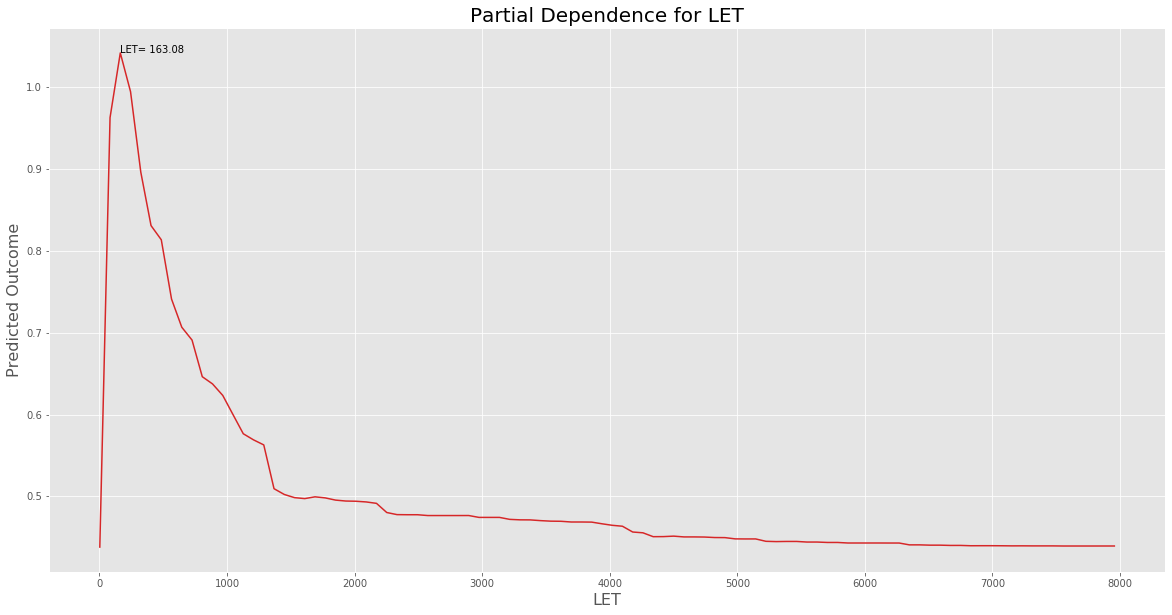

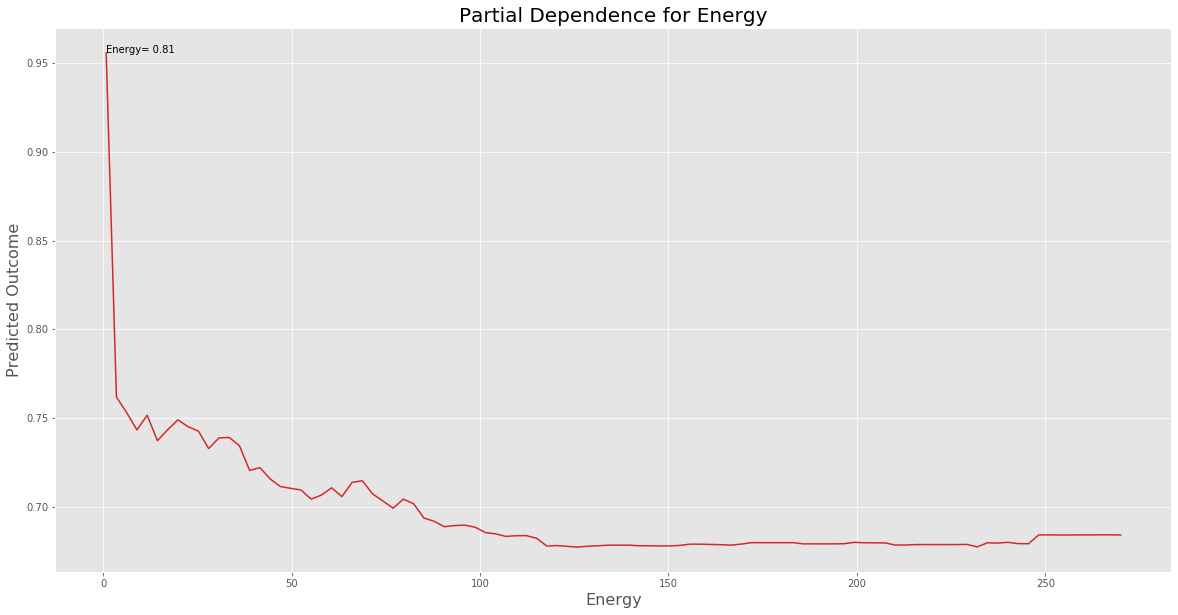

2-way partial dependence plots
[900/900] grid cells ████████████████████ Time elapsed: 4 secondsai_paper local Interpretations
bi_paper global Interpretations
bi_paper Feature Importances
bi_paper Partial Dependene


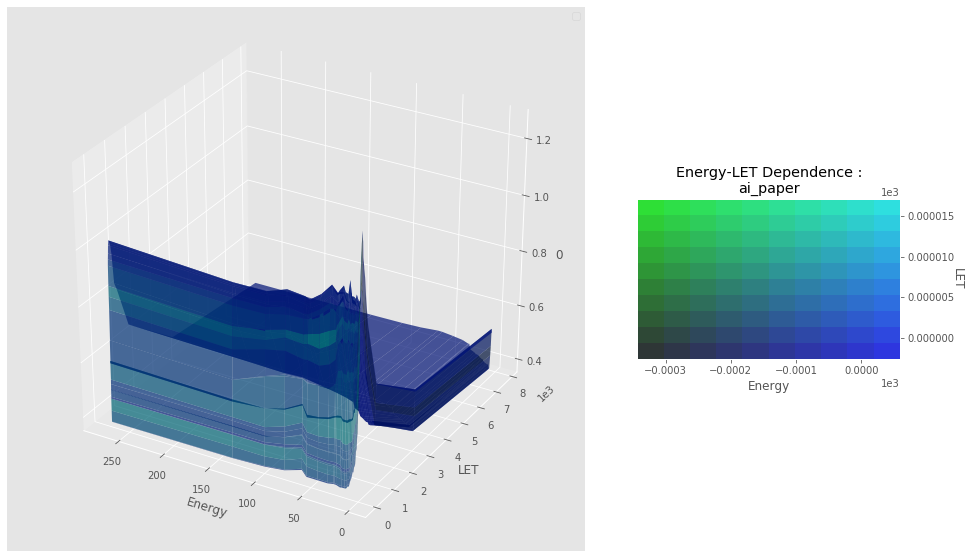

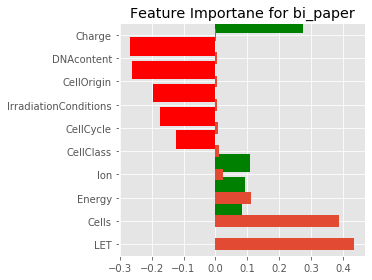

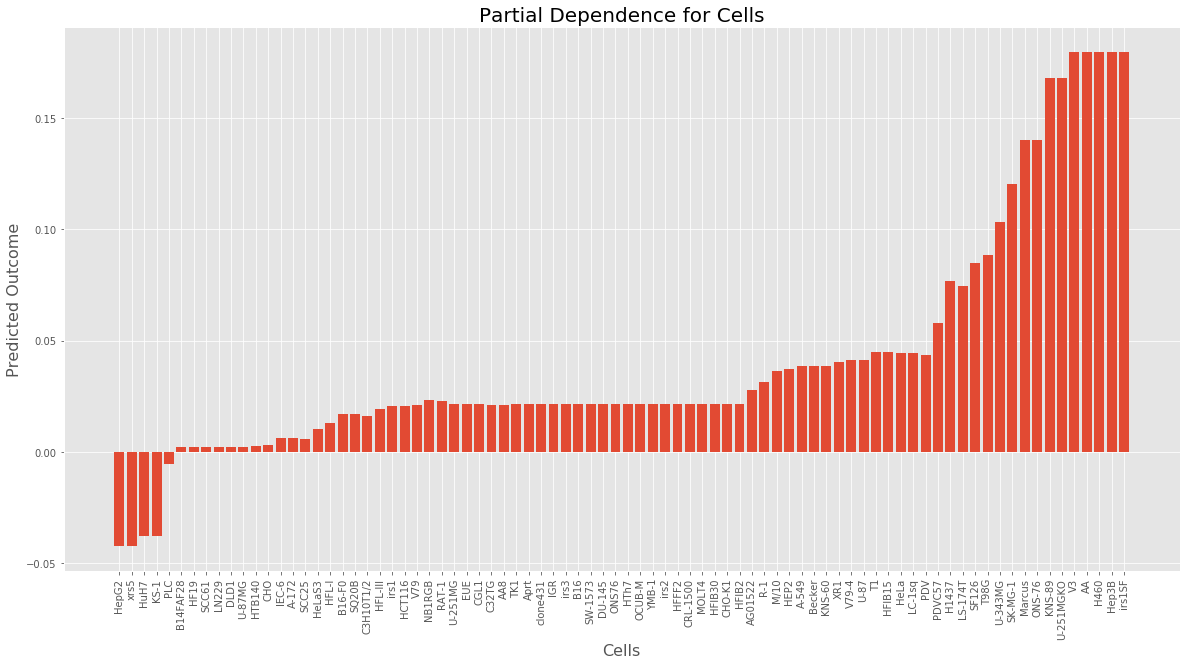

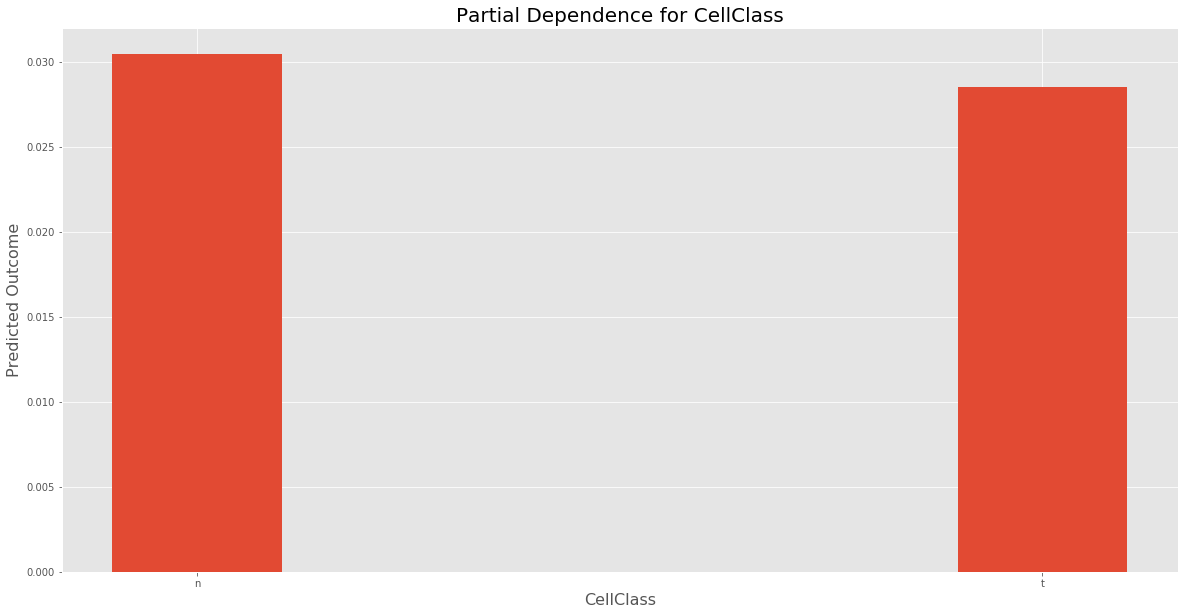

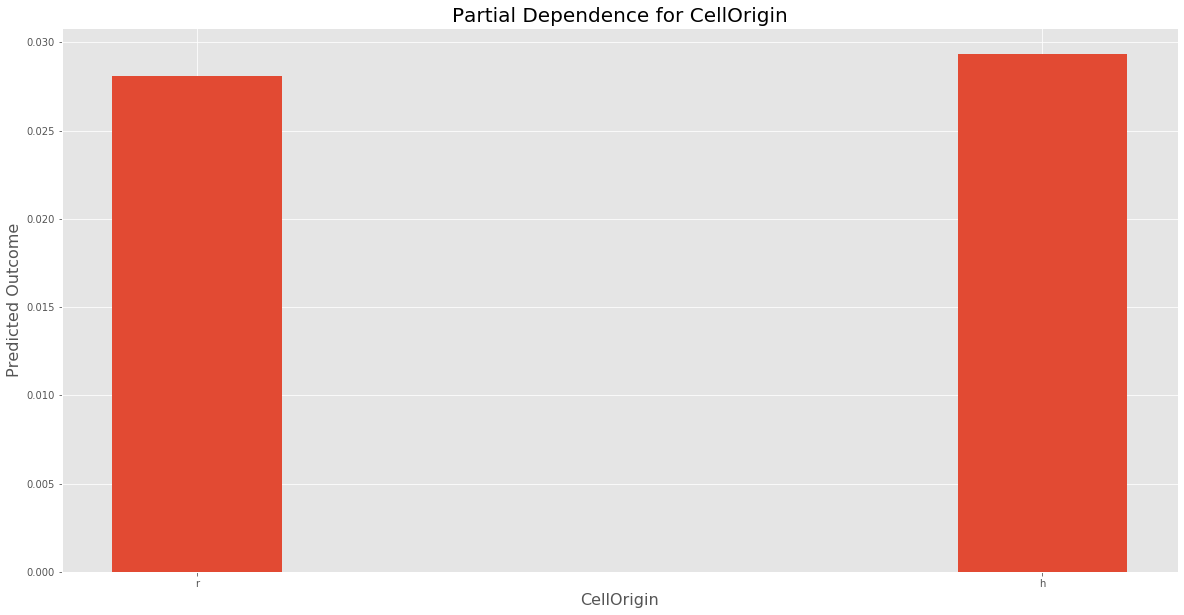

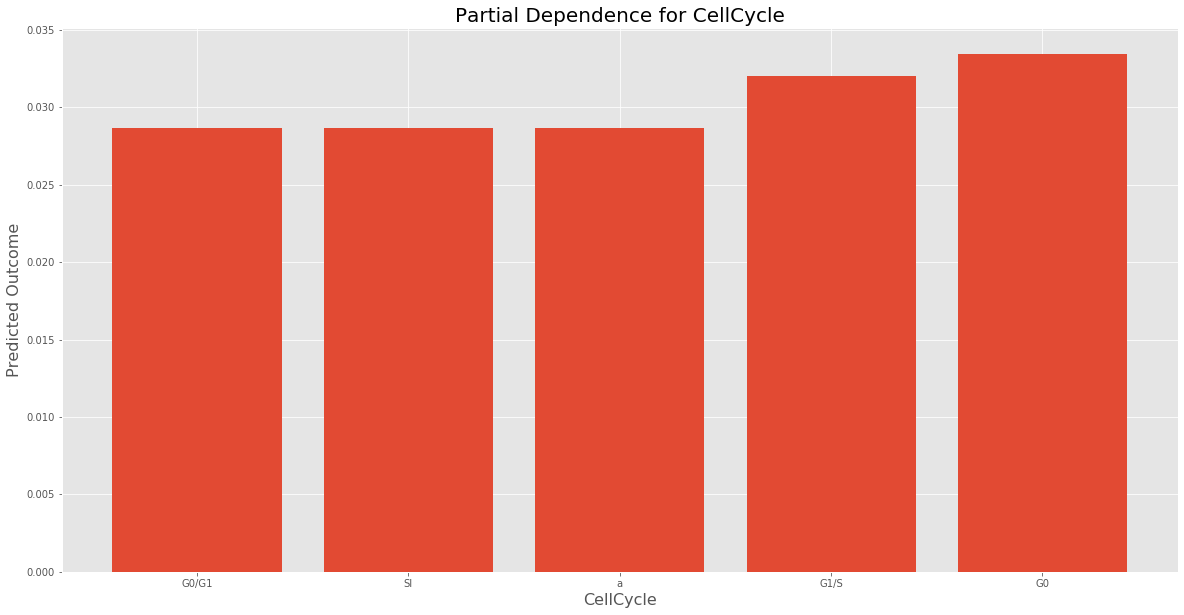

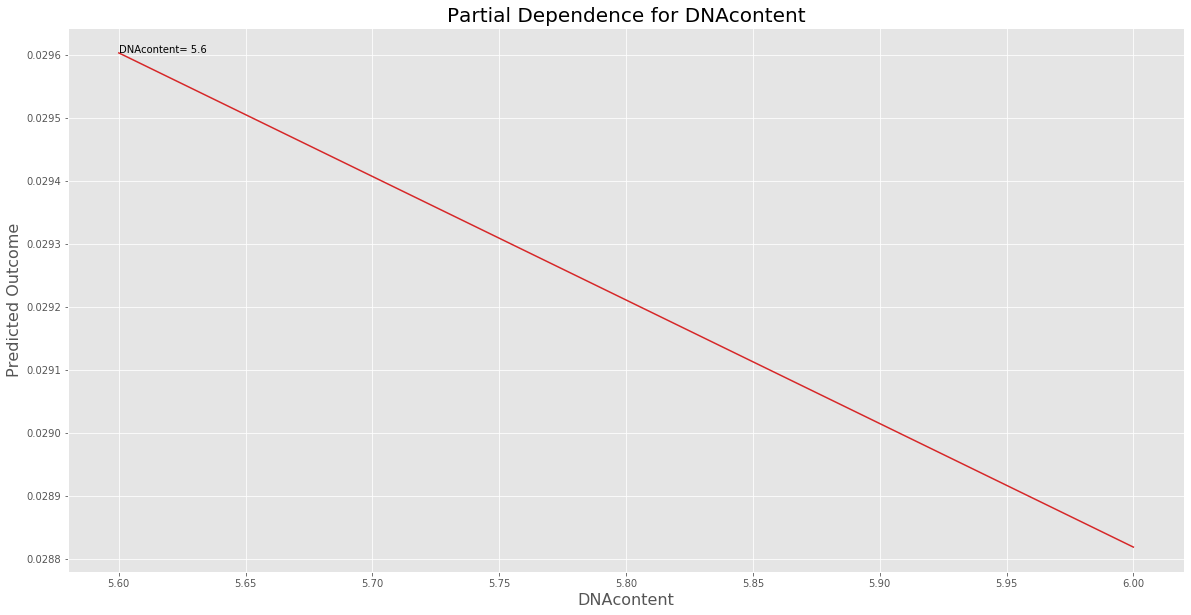

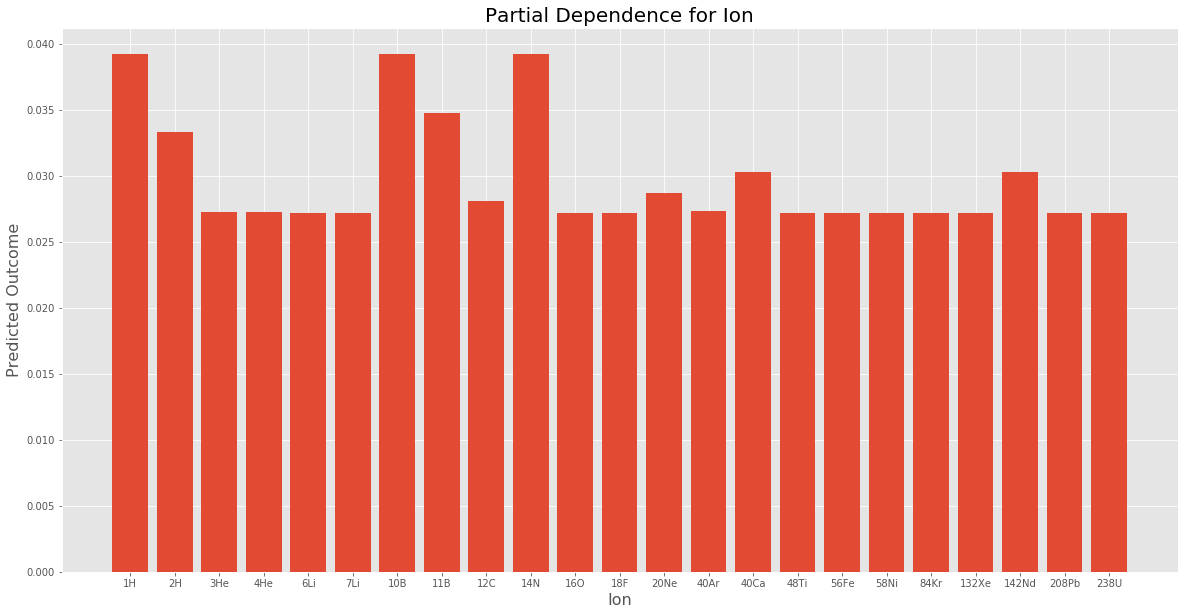

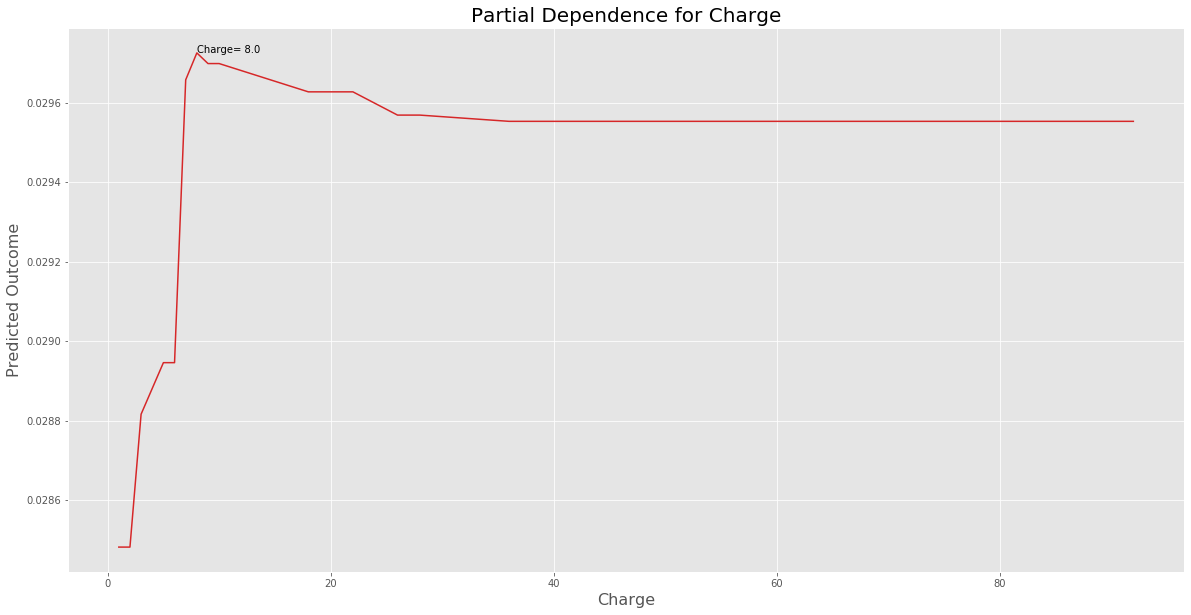

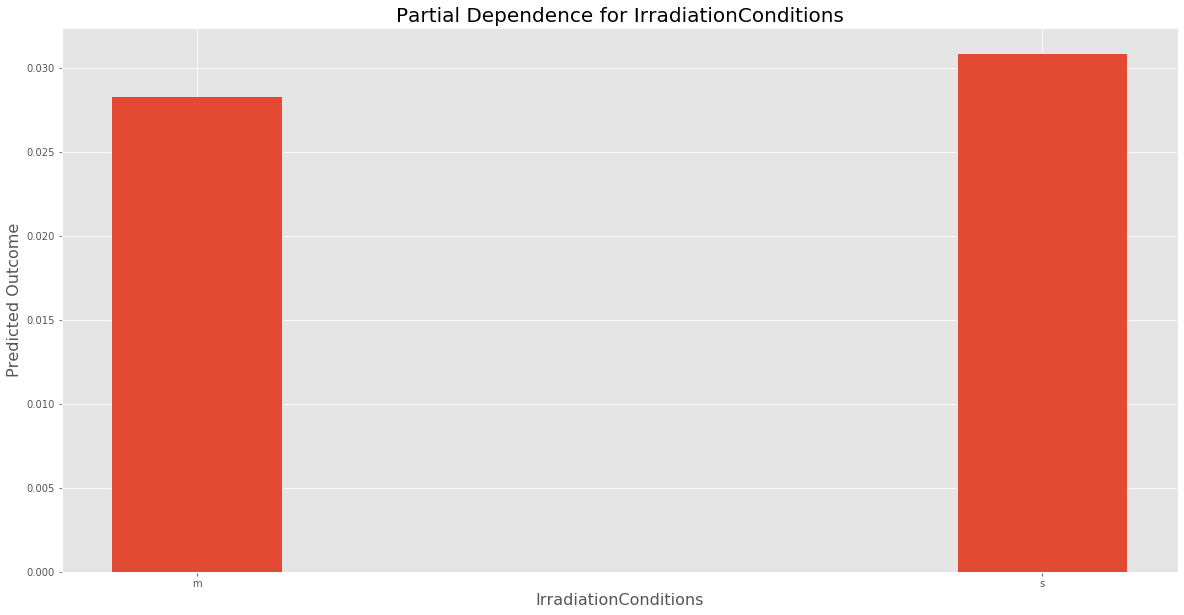

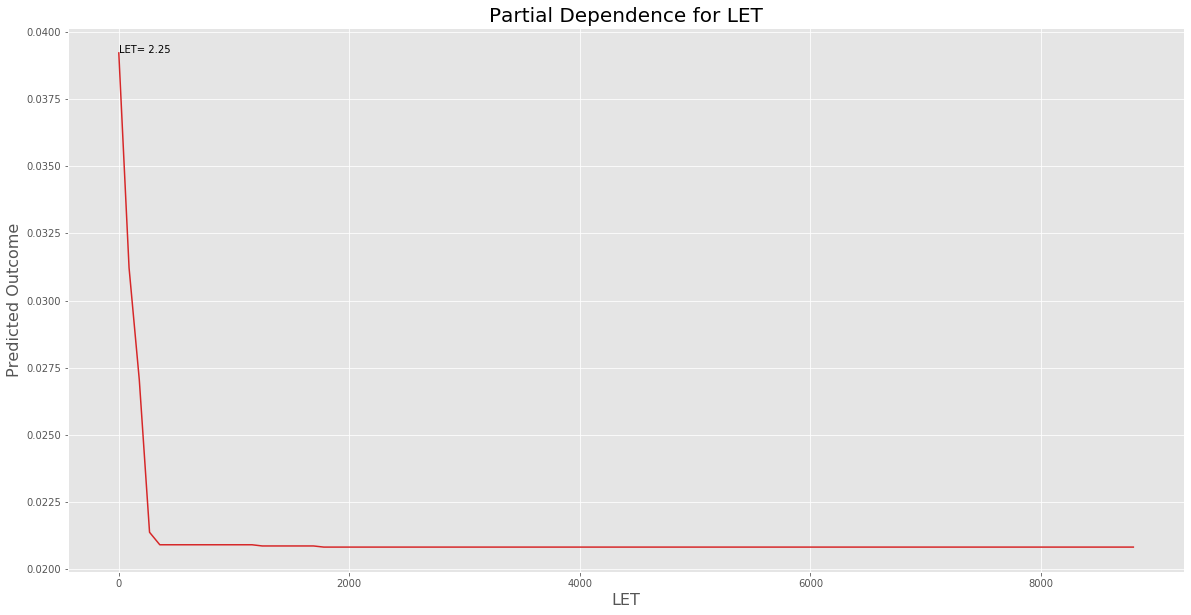

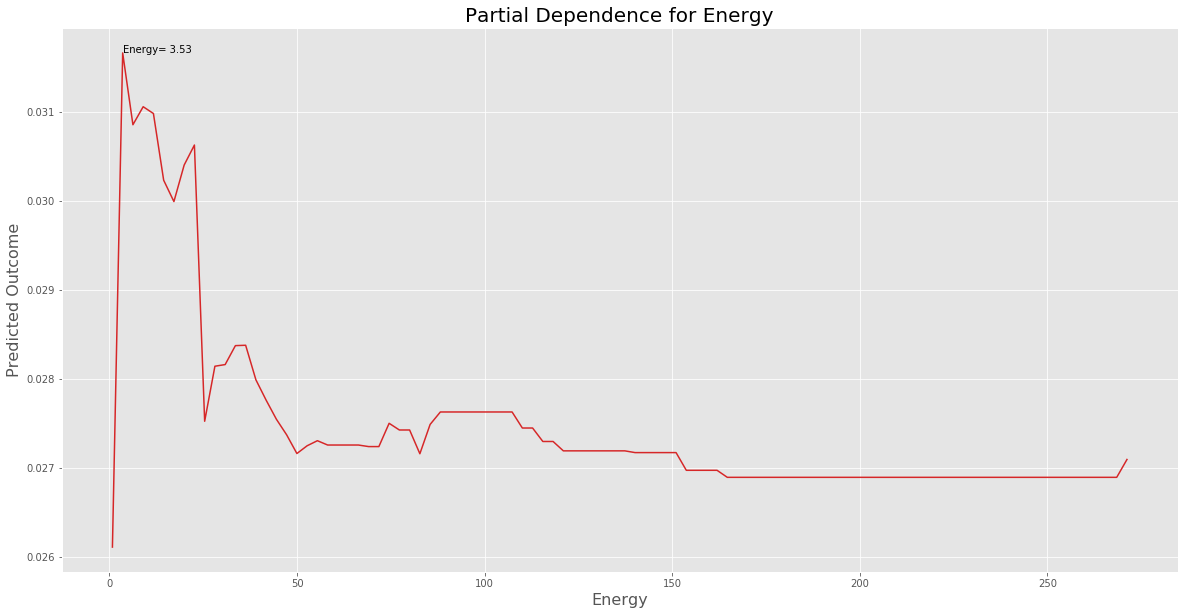

2-way partial dependence plots
[900/900] grid cells ████████████████████ Time elapsed: 2 secondsbi_paper local Interpretations
DSBs_hy global Interpretations
DSBs_hy Feature Importances
DSBs_hy Partial Dependene


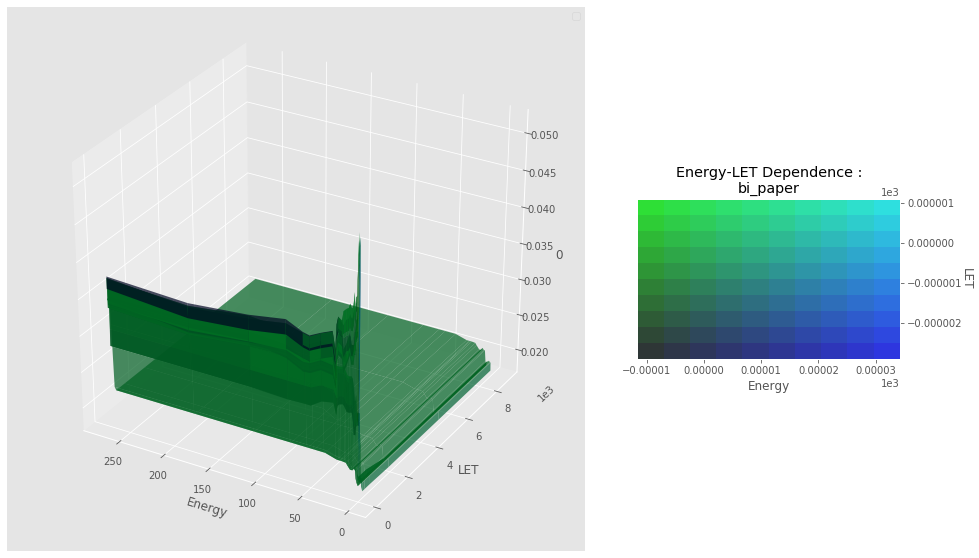

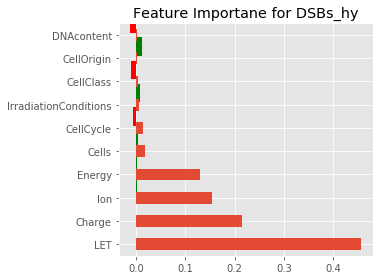

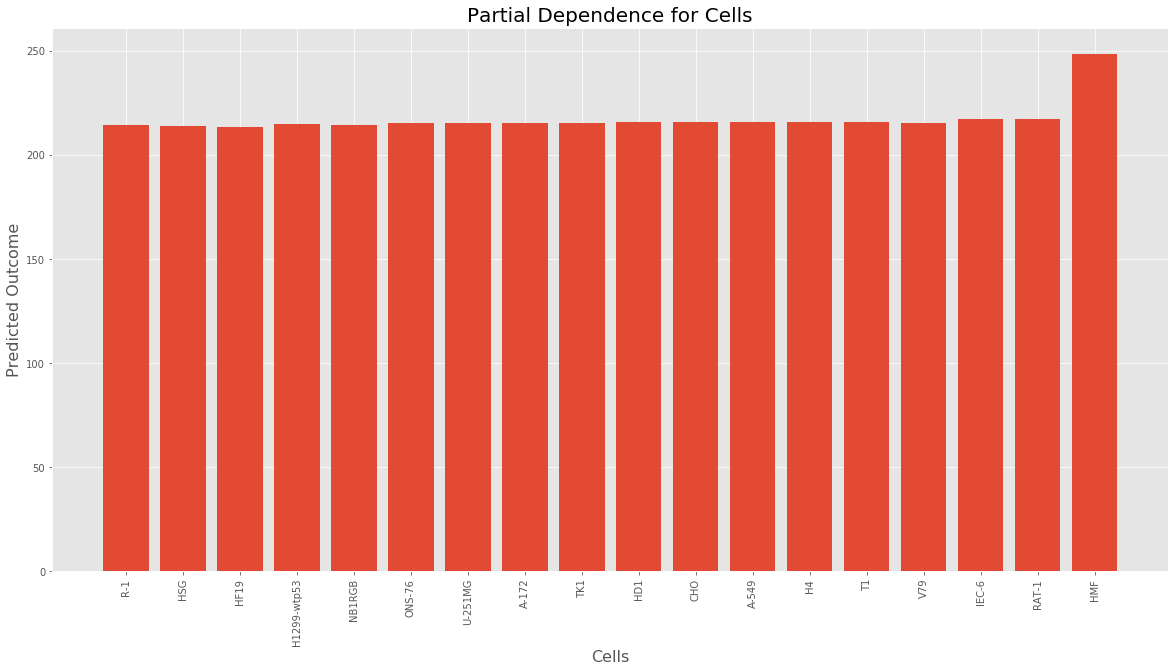

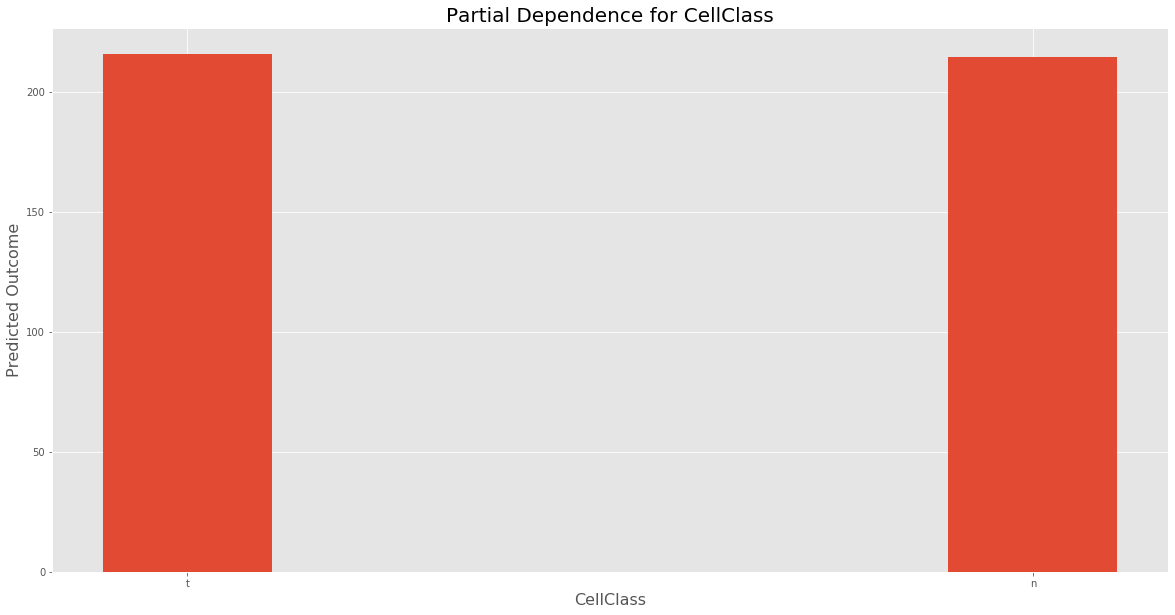

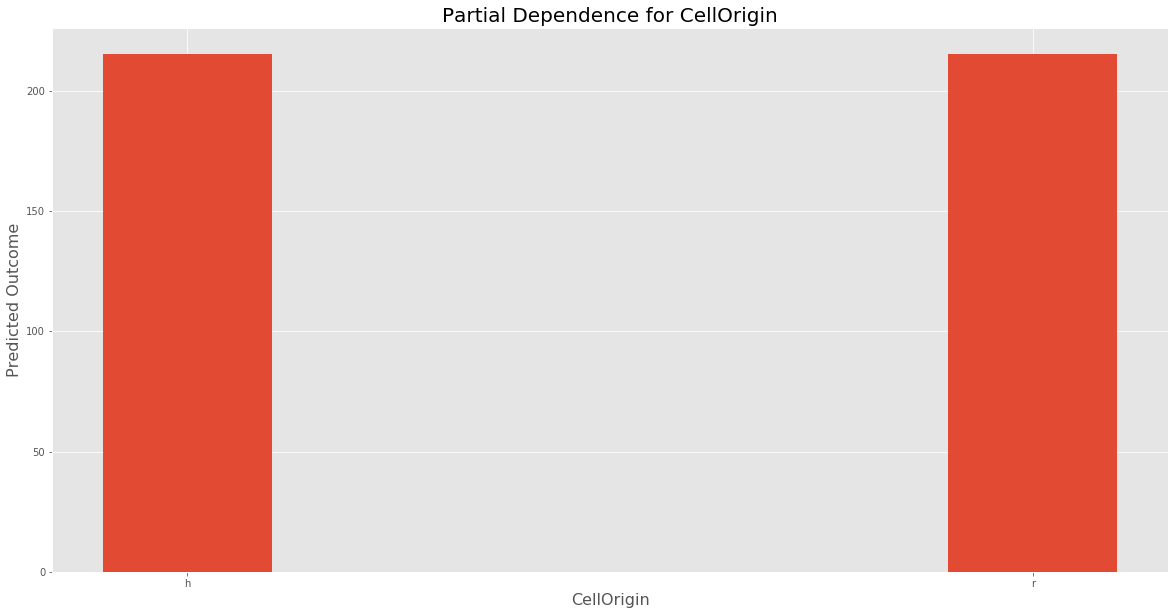

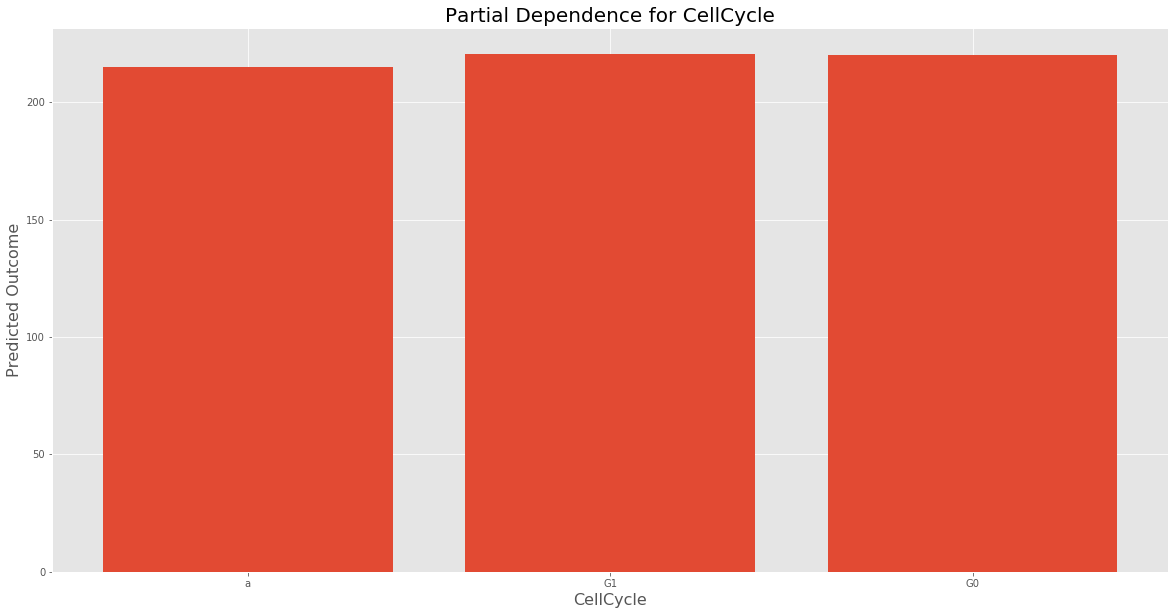

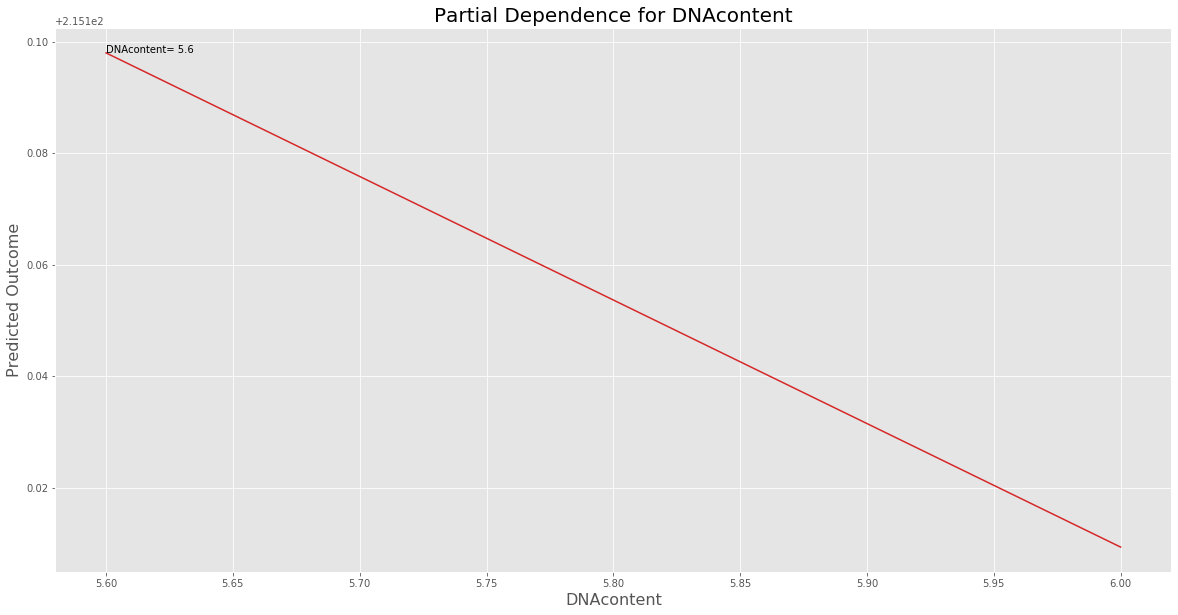

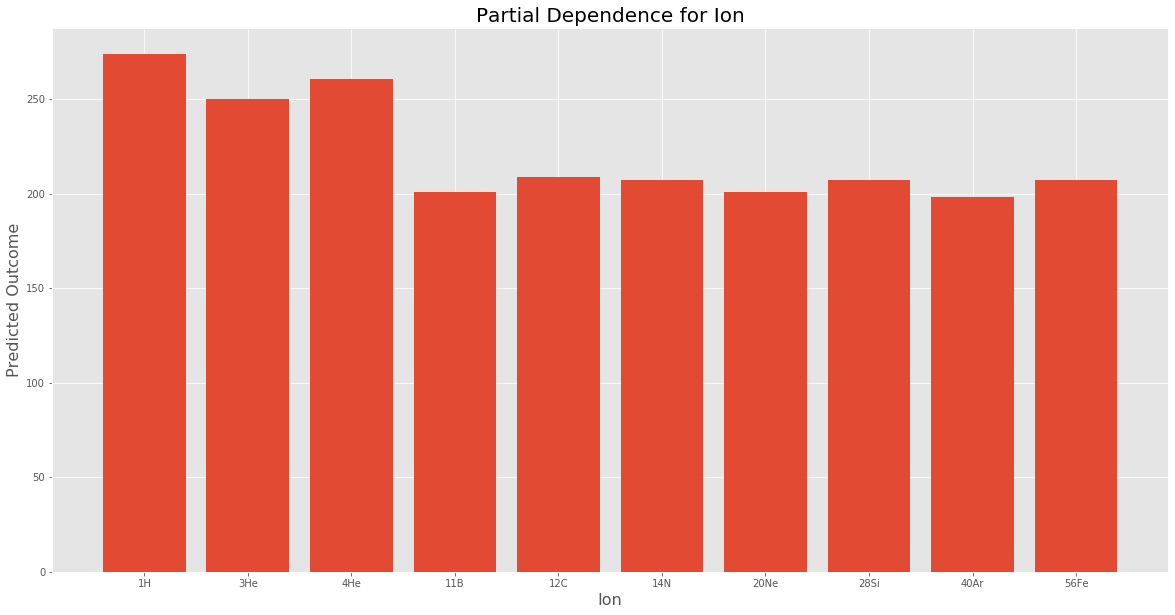

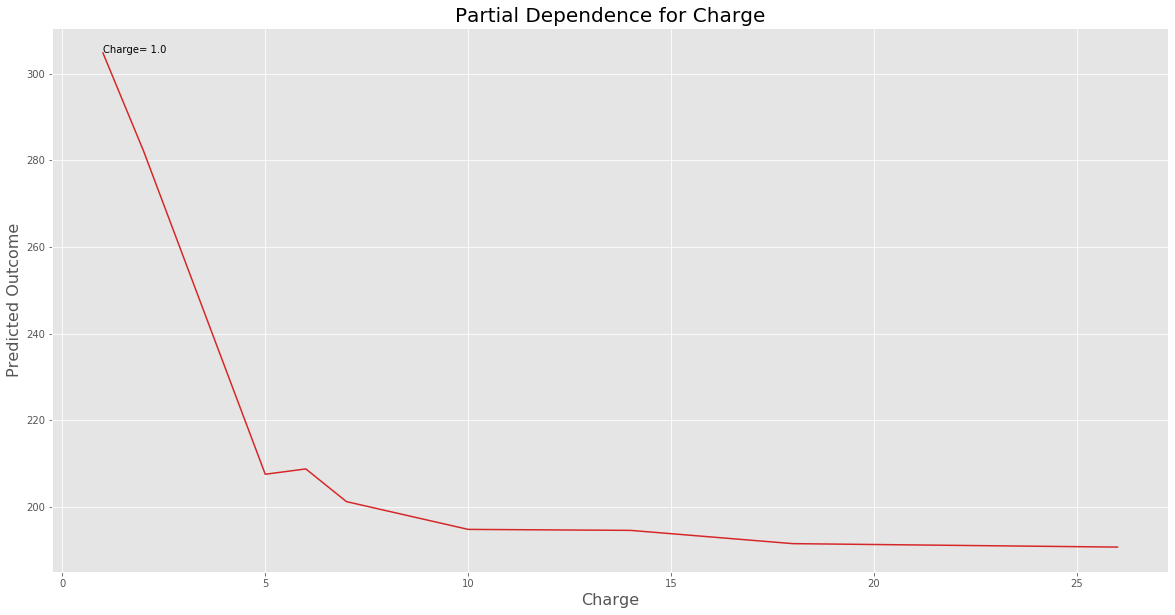

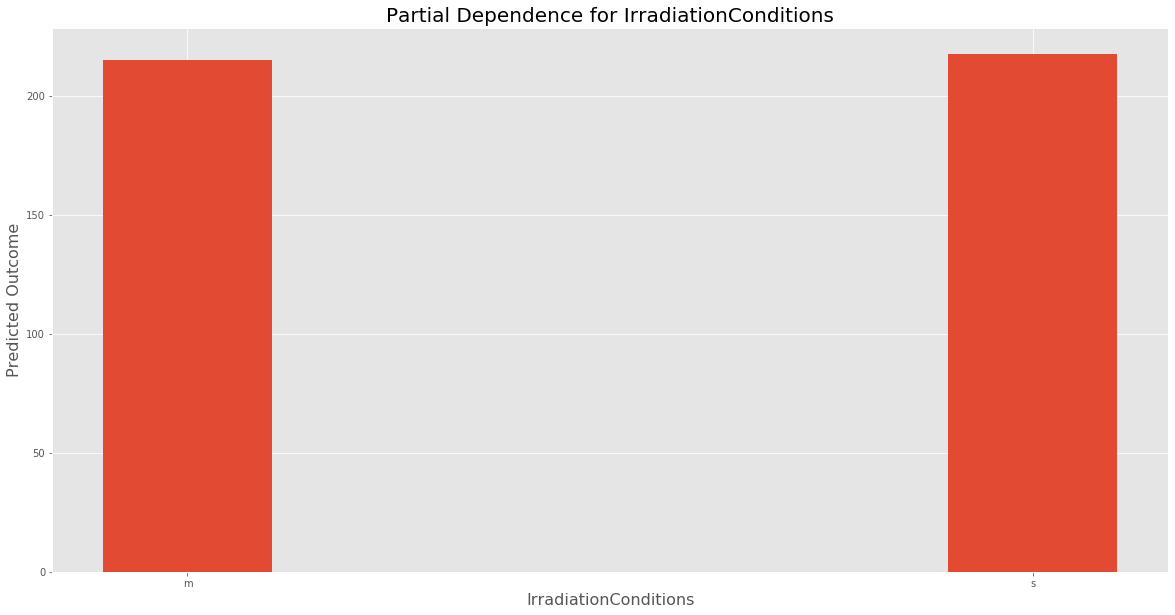

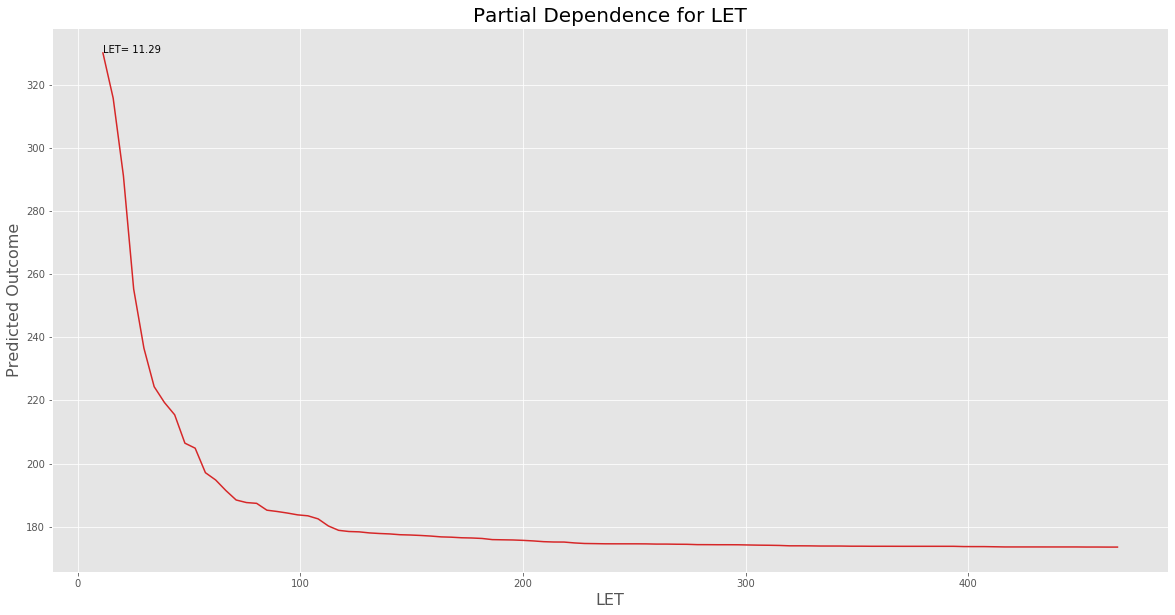

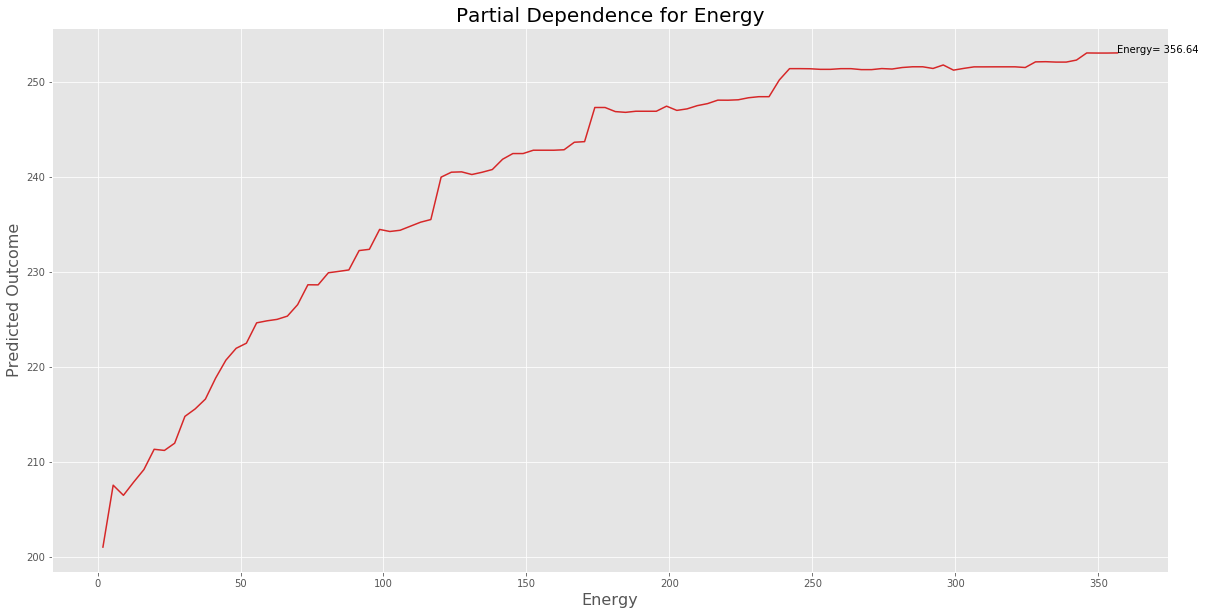

2-way partial dependence plots
[900/900] grid cells ████████████████████ Time elapsed: 5 secondsDSBs_hy local Interpretations


/home/dimitris/Documents/papers/grain_of_salt/miniconda/envs/skater-test/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.95631e-18): result may not be accurate.
  overwrite_a=True).T


DSBs_ox global Interpretations
DSBs_ox Feature Importances
DSBs_ox Partial Dependene


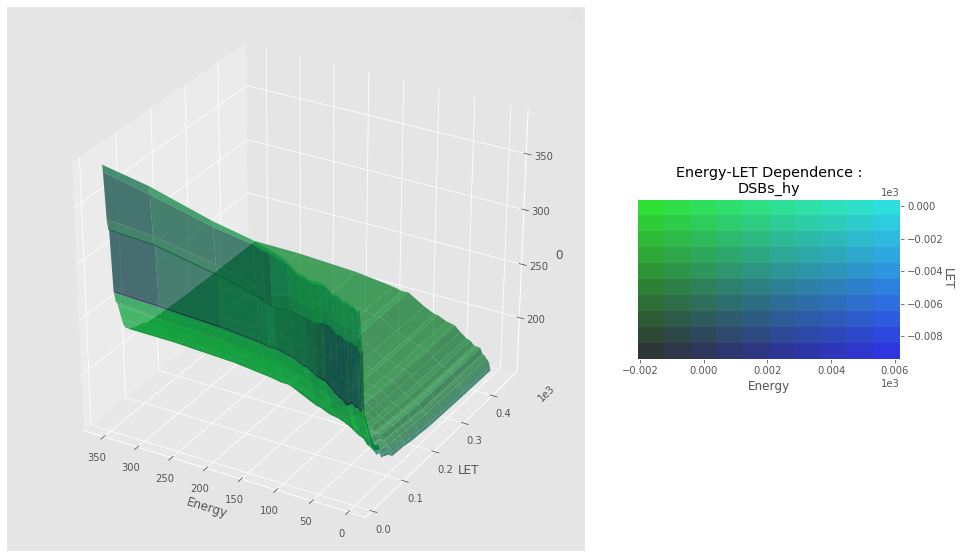

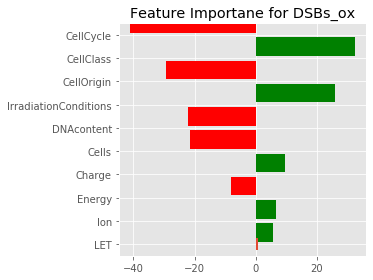

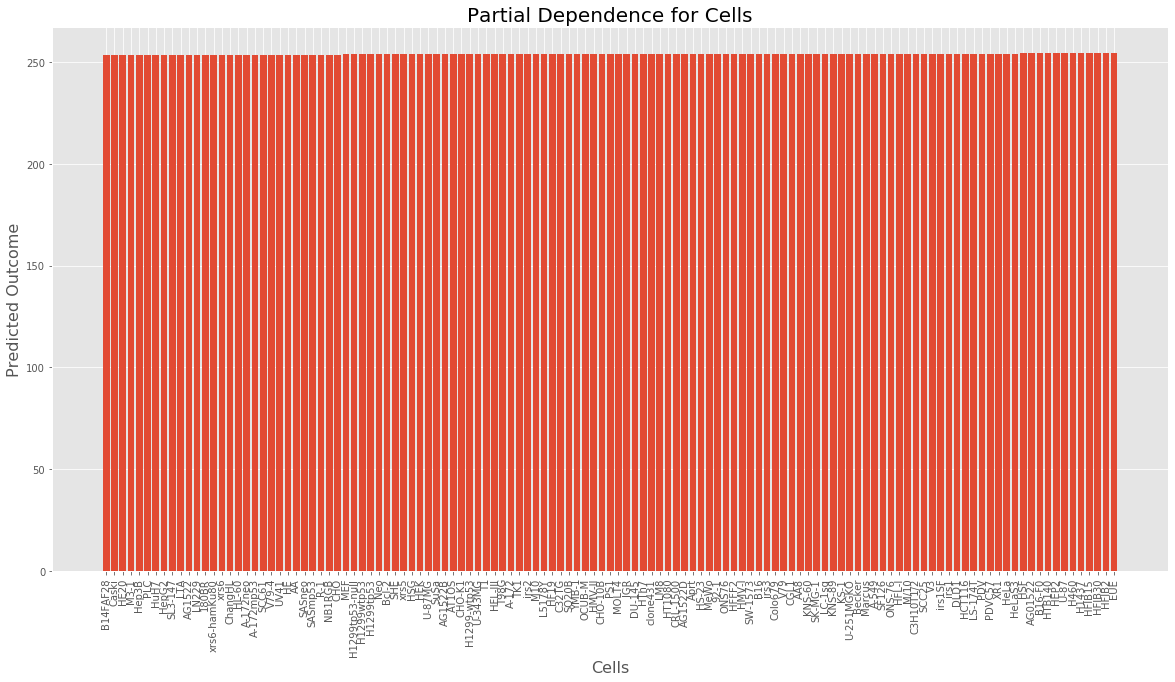

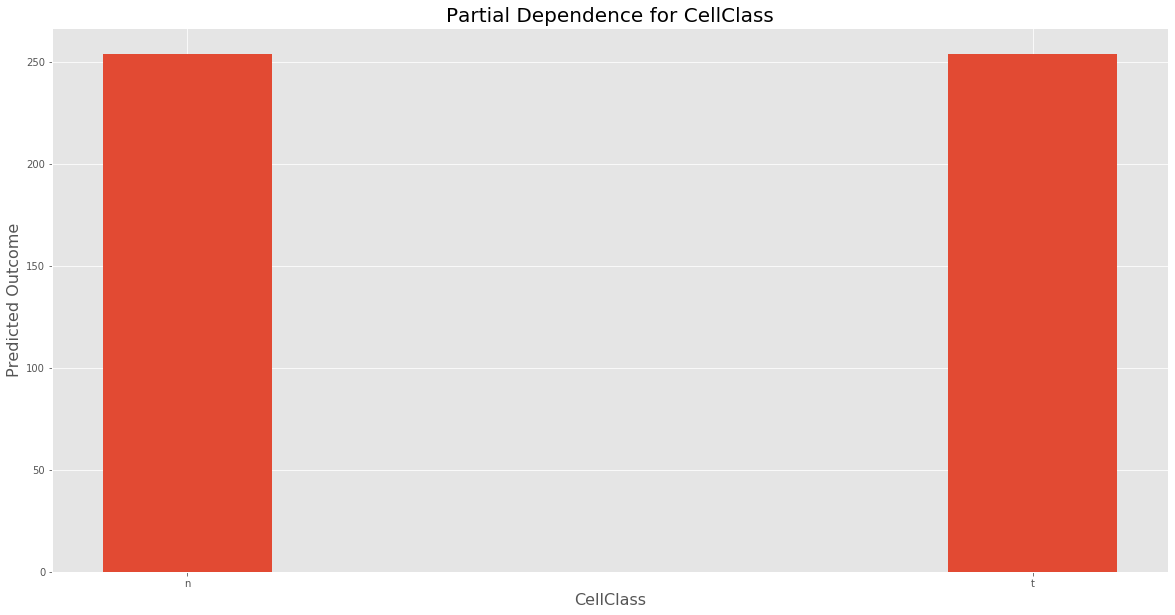

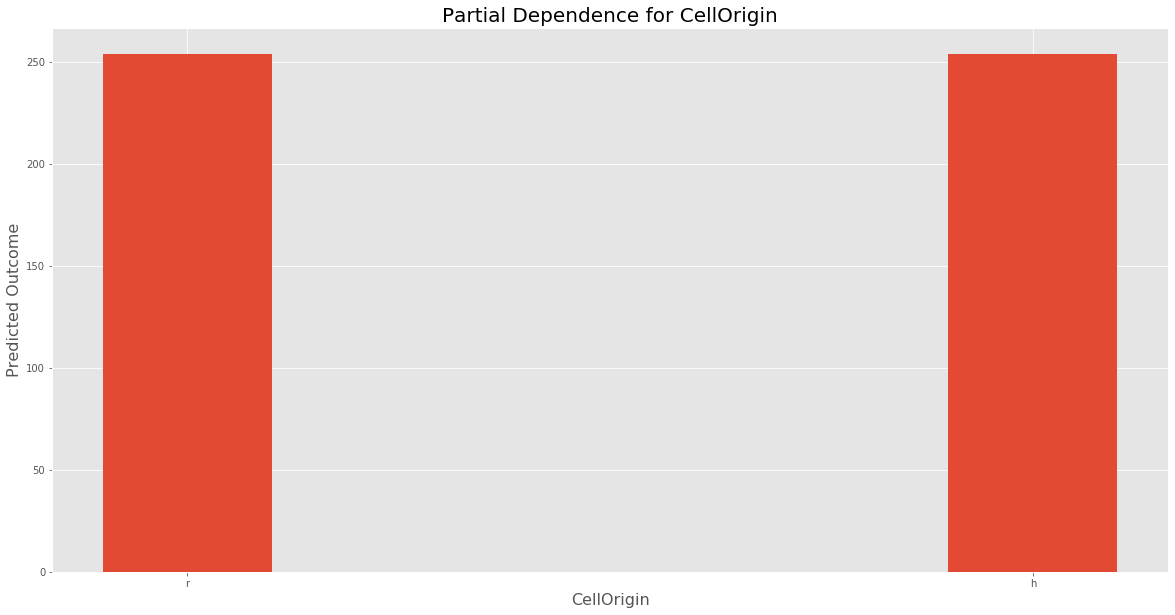

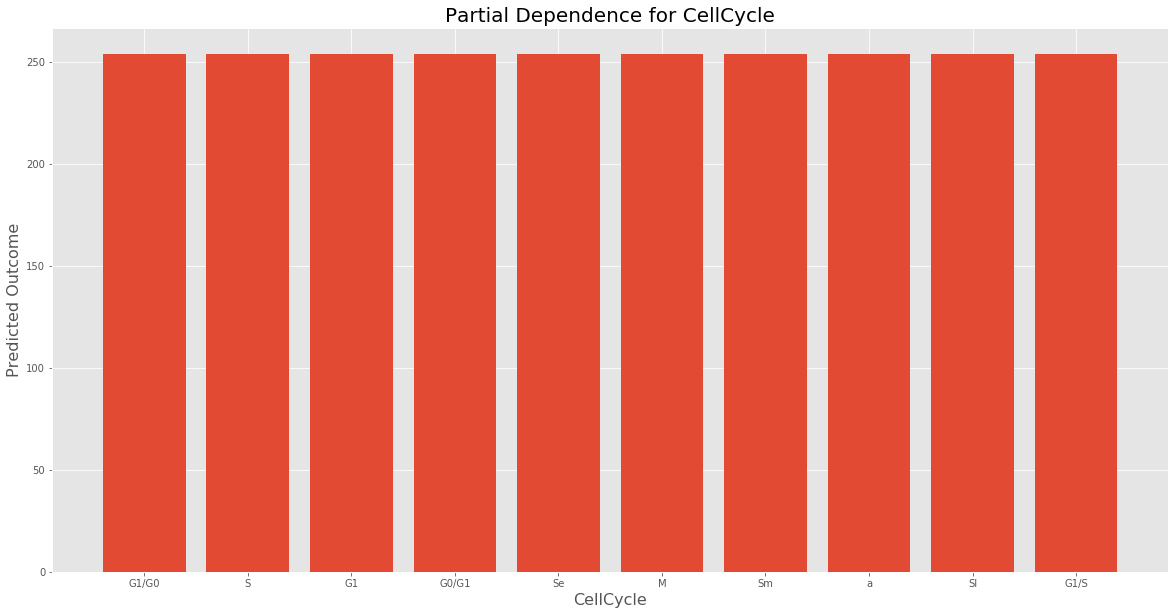

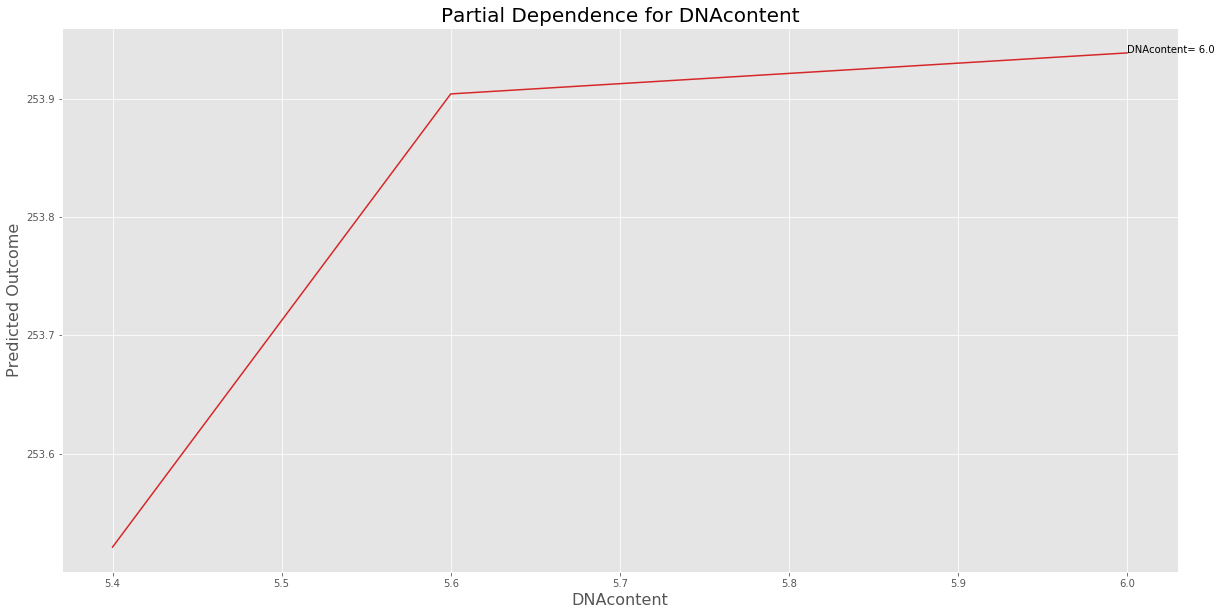

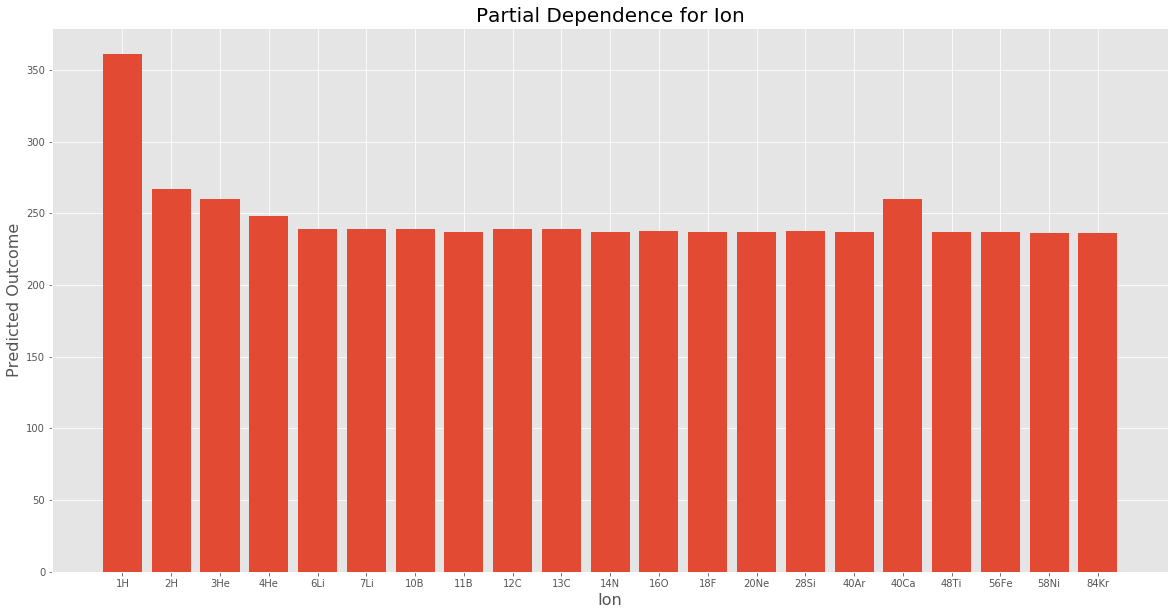

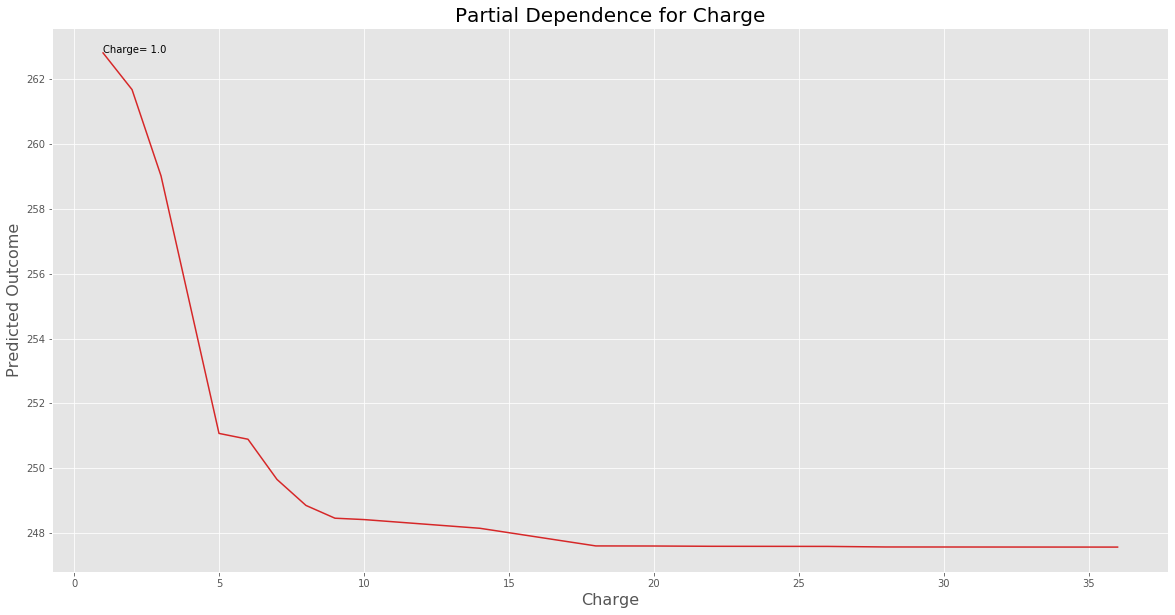

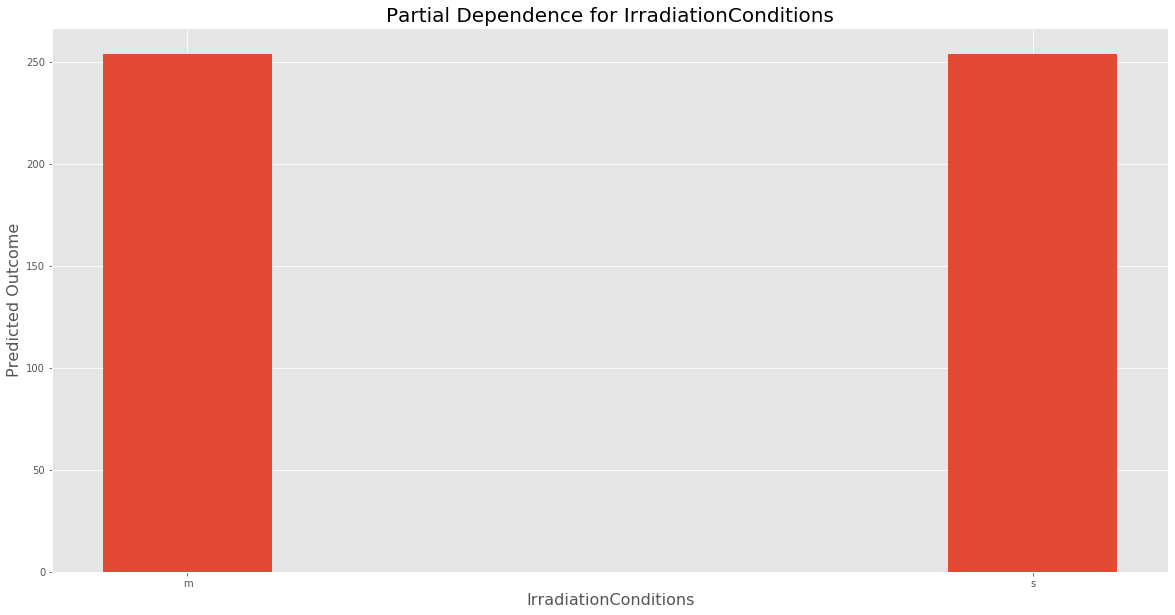

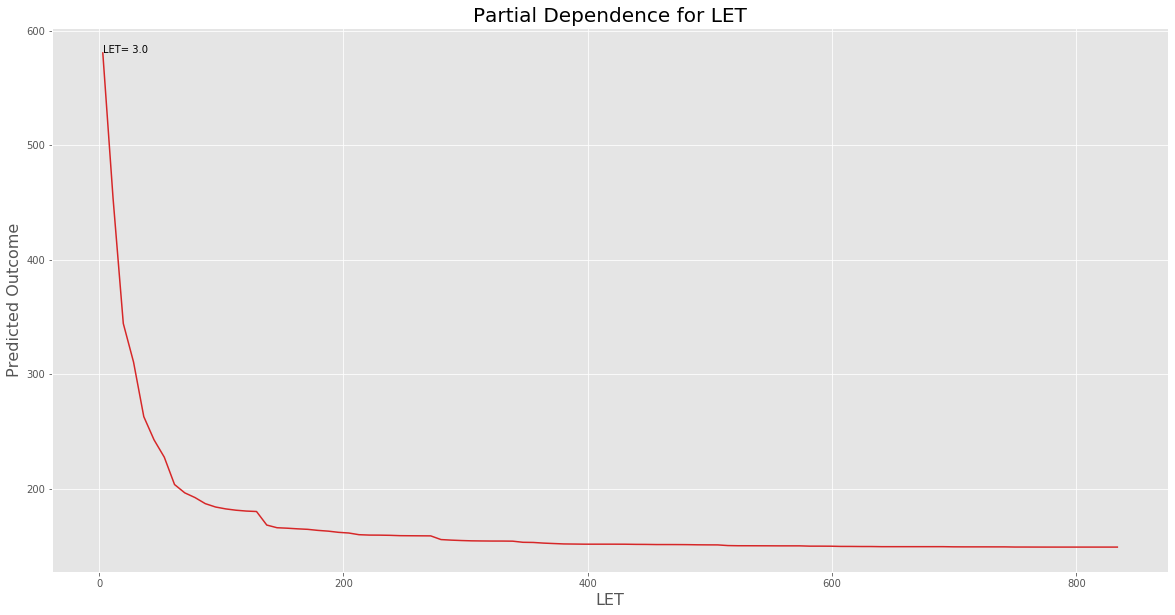

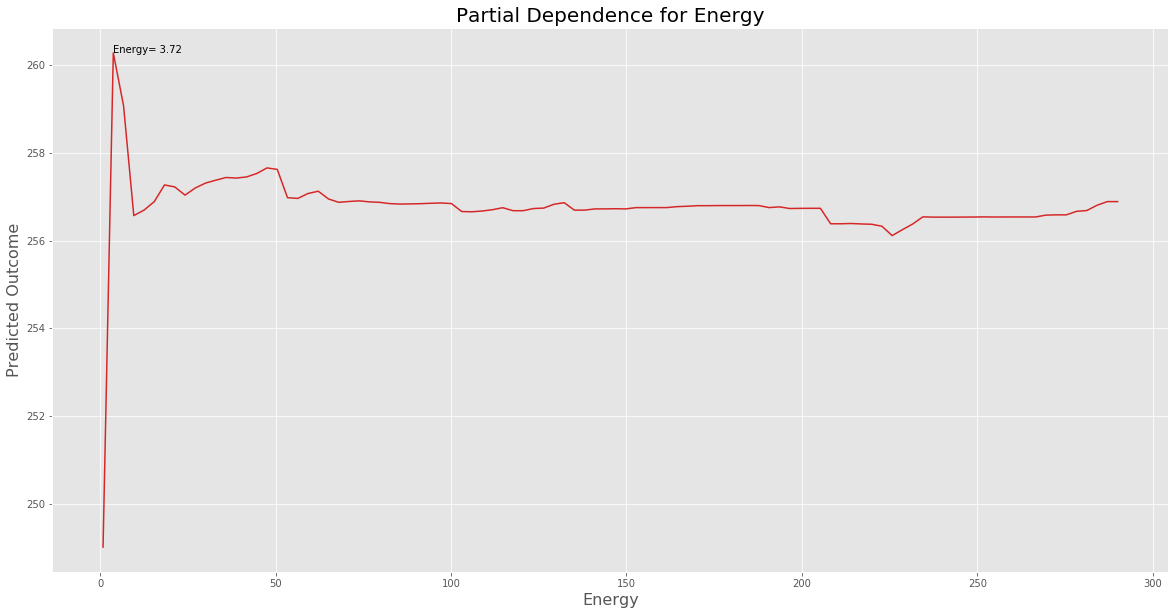

2-way partial dependence plots
[900/900] grid cells ████████████████████ Time elapsed: 4 secondsDSBs_ox local Interpretations


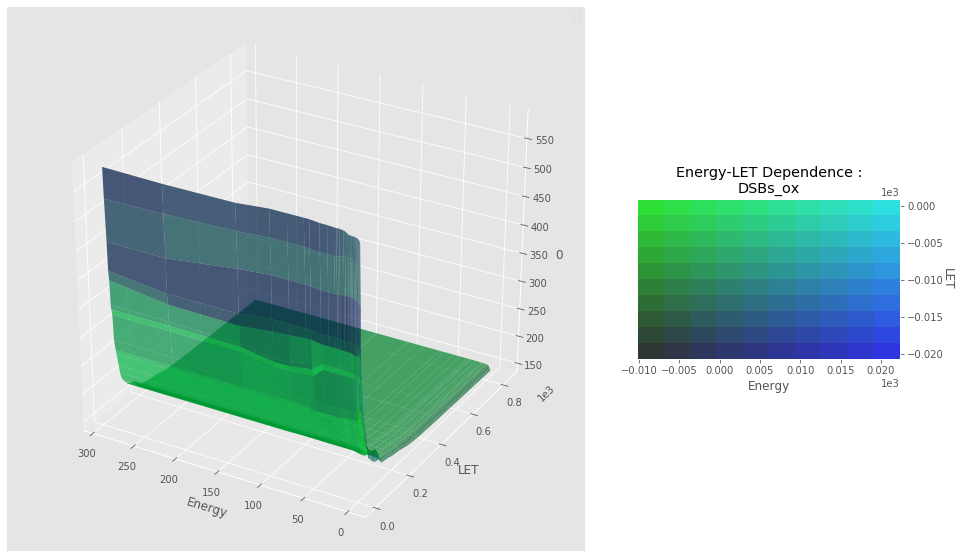

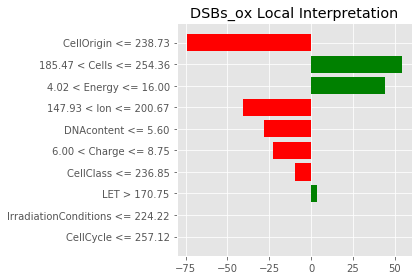

In [173]:
from skater.core.explanations import Interpretation
from skater.data import DataManager
from skater.model import InMemoryModel
from skater.model import DeployedModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

def interpretations(model,target,X,dict_,number):
    ########## Importance ###############
    print(target+" Feature Importances")
    pd.Series(model.feature_importances_, index=features).nlargest(11).\
    plot(kind='barh',title='Feature Importane for '+target)
    ########## Partial Dependence #######
    print(target + ' Partial Dependene')
    for feature in features:
        plot_pd(feature,cat_features, model,X, dict_)
    ########## 2-way partial dependence plots #####
    predict = lambda z: model.predict(z).astype(float)
    interpreter = Interpretation()
    annotated_model = InMemoryModel(predict, examples=X)
    interpreter = Interpretation()
    interpreter.load_data(X,feature_names=features)
    print("2-way partial dependence plots")
    pdp_features = [('Energy','LET')]
    interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, annotated_model, grid_resolution=30,
    )
    plt.title('Energy-LET Dependence :\n'+ target)
    return None

def local_interpretation(model,X,features,cat_features,instance, target):
    predict = lambda z: model.predict(z).astype(float)
    # create an explainer
    explainer = LimeTabularExplainer(X.values, feature_names=features,
                                     mode="regression",
                                     kernel_width=3,
                                     categorical_features=cat_features,
                                    )
    # explain something
    explanation = explainer.explain_instance(instance,predict, num_samples=10)
    # show the explanation
#     explanation.show_in_notebook()
    explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.title(target + ' Local Interpretation')
#     plt.close()
    return None

parameters = []
with open('best_params.txt') as f:
    for jsonObj in f:
        paramDict = json.loads(jsonObj)
        parameters.append(paramDict)

    for obj in parameters:
        target = obj['target']
        X , y , encoding_dict_ = prepare_data(excel,target,features,split=False)
        model = RandomForestRegressor()
        params = obj['params']
        model.set_params(**params)
        model.fit(X,y)
        print(target+' global Interpretations')
        interpretations(model,target,X, encoding_dict_,counter)
        print(target+' local Interpretations')
        local_interpretation(model,X,features,cat_features,X.iloc[0].values,target)